# **Thông tin nhóm**
## Mã nhóm: 20CQ.PTDL.05
## Danh sách thành viên:
*   20120466 - Trần Thị Thu Hà
*   20120592 - Lê Minh Tiến
*   20120595 - Phạm Minh Tiến
*   20120624 - Mai Quyết Vang



# Thêm thư viện cần thiết

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Load dữ liệu

In [129]:
link_p1 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p1.xlsx"
link_p2 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p2.xlsx"


In [130]:
# Đọc dữ liệu từ file Excel
Data_Train_p1 = pd.read_excel(link_p1)
Data_Train_p2 = pd.read_excel(link_p2)

# Ghép nối hai DataFrame
merged_data = pd.concat([Data_Train_p1, Data_Train_p2], ignore_index=True)


# **Preprocessing**

## Xử lí duplicate: Xóa các dòng bị trùng lặp

In [131]:
# Kiểm tra duplicate data và sắp xếp theo cột để dòng trùng lặp gần nhau
duplicates = merged_data[merged_data.duplicated(keep=False)].sort_values(by=merged_data.columns.tolist())

if len(duplicates) > 0:
    print("Có {} dòng dữ liệu bị trùng lặp.".format(len(duplicates)))
    duplicates.to_excel('duplicate_data.xlsx', index=False)
else:
    print("Không có dòng dữ liệu trùng lặp.")
print("Số dòng dữ liệu trước khi xóa các dòng trùng lặp:")
print(merged_data.shape[0])


# Xóa các dòng dữ liệu bị trùng, chỉ giữ lại dòng có index nhỏ hơn (bên trên)
merged_data = merged_data.drop_duplicates(keep='first')
print("Số dòng dữ liệu sau khi xóa các dòng trùng lặp:")
print(merged_data.shape[0])

Có 417 dòng dữ liệu bị trùng lặp.
Số dòng dữ liệu trước khi xóa các dòng trùng lặp:
10684
Số dòng dữ liệu sau khi xóa các dòng trùng lặp:
10463


## Unique dữ liệu cột additional_info

In [132]:

#df.info()
def to_lower(df):
  string_cols = ['Additional_Info']
  for i in string_cols:
    df[i] = df[i].apply(lambda s: s.lower())
  return df

merged_data = to_lower(merged_data)
merged_data['Additional_Info'].unique()

array(['no info', 'in-flight meal not included',
       'no check-in baggage included', '1 long layover',
       'change airports', 'business class', 'red-eye flight',
       '2 long layover', '1 short layover'], dtype=object)

## Thêm cột Day

In [133]:
#Vì có sẵn month nên thêm day để bỏ date_of_journey
#merged_data['Date_of_Journey'] = pd.to_datetime(merged_data['Date_of_Journey'])
merged_data['Date_of_Journey'] = pd.to_datetime(merged_data['Date_of_Journey'], dayfirst=True)

# Extract day and create a new column
merged_data['Day'] = merged_data['Date_of_Journey'].dt.day

## Chuyển Duration thành phút (int): Chuyển đổi từ kiểu giờ-phút về kiểu int để tiện cho các tính toán bên dưới. Và thêm cột Duration_hour ví dụ 110 phút thì làm trong thành 2 (h).
*Lí do: Để tiện cho các phân tích liên quan đến Duration. Nếu để kiểu cũ là kiểu string thì khó để phân tích.*


In [134]:
# Chuyển đổi cột 'Duration' về đơn vị phút
def convert_duration(duration):
    if 'h' in duration and 'm' in duration:
        return int(duration.split('h')[0]) * 60 + int(duration.split('h')[1].split('m')[0])
    elif 'h' in duration:
        return int(duration.split('h')[0]) * 60
    elif 'm' in duration:
        return int(duration.split('m')[0])
    else:
        return 0

merged_data['Duration'] = merged_data['Duration'].apply(convert_duration)

# Thêm cột Duration_Hour
merged_data['Duration_Hour'] = round(merged_data['Duration'] / 60)

# Chuyển đổi kiểu dữ liệu của cột Duration_Hour sang số nguyên
merged_data['Duration_Hour'] = merged_data['Duration_Hour'].astype(int)

## Thêm cột Dep_hour (ví dụ 16:05 hay 16:15 thì thành 16 (h))
*Lí do: Vì nếu k xử lý thì có quá nhiều mốc thời gian bay ví dụ 16:05, 16:10, 16:15, mà có phân tích bên dưới không cần quan tâm đến thời gian cụ thể mà chỉ cần quan tâm khoảng thời gian.*

In [135]:
# Thêm cột Dep_hour
merged_data['Dep_hour'] = pd.to_datetime(merged_data['Dep_Time']).dt.hour

C:\Users\Vanniee\AppData\Local\Temp\ipykernel_23332\2483593684.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Dep_hour'] = pd.to_datetime(merged_data['Dep_Time']).dt.hour


## Chuyển Total_stop thành kiểu int

In [136]:
# Chuyển Total_Stops về kiểu int, giữ lại giá trị null
merged_data['Total_Stops'] = merged_data['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4, '': np.nan}).fillna('Blanks')

## Xử lí cột Date_of_Journey: xử lí thành cùng định dạng (dd/mm/yyyy)

In [137]:
merged_data['Date_of_Journey'] = pd.to_datetime(merged_data['Date_of_Journey'], format='%d/%m/%Y', errors='coerce')
merged_data['Month'] = merged_data['Date_of_Journey'].dt.month
merged_data['WeekDay'] = merged_data['Date_of_Journey'].dt.day_name()
#Appending weekend column
merged_data['Weekend'] = merged_data['WeekDay'].apply(lambda day: 1 if day == 'Sunday' else 0)
merged_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,0.0,no info,3897,24,3,22,3,Sunday,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2.0,no info,7662,1,7,5,5,Wednesday,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2.0,no info,13882,9,19,9,6,Sunday,1
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1.0,no info,6218,12,5,18,5,Sunday,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1.0,no info,13302,1,5,16,3,Friday,0


## Tính lại Arrival_Time, do có một vài Arrival_Time chưa chính xác, vì Arrival_Time phải bằng Dep_Time+ Duration (và còn phụ thuộc vào Date of Journey), nên tính lại Arrival_Time dựa vào 3 cột đó

In [138]:
# Hàm tùy chỉnh để xử lý ngày trong 'Arrival_Time'
def extract_arrival_day(row):
    date_of_journey = row['Date_of_Journey'].strftime('%Y-%m-%d')
    dep_time = row['Dep_Time'].strip()  # Strip extra spaces

    # Chuyển đổi Departure Time thành đối tượng datetime
    dep_datetime = datetime.strptime(str(date_of_journey) + ' ' + dep_time, '%Y-%m-%d %H:%M')

    # Tính thời gian di chuyển thành đối tượng timedelta
    duration_minutes =  row['Duration']
    travel_duration = timedelta(minutes=duration_minutes)

    # Tính thời gian đến (Arrival Time) bằng cách cộng thêm thời gian di chuyển vào Departure Time
    arrival_datetime = dep_datetime + travel_duration

    #Trả về ngày đến dưới dạng chuỗi 'dd/mm/yyyy'
    return arrival_datetime.strftime('%d/%m/%Y')


# Áp dụng hàm cho cột 'Arrival_Day'
merged_data['Arrival_Date'] = pd.to_datetime(merged_data.apply(extract_arrival_day, axis=1), format='%d/%m/%Y', errors='coerce')

merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%H:%M')

merged_data.head()

C:\Users\Vanniee\AppData\Local\Temp\ipykernel_23332\3877452211.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%H:%M')


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend,Arrival_Date
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10,170,0.0,no info,3897,24,3,22,3,Sunday,1,2019-03-25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2.0,no info,7662,1,7,5,5,Wednesday,0,2019-05-01
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,1140,2.0,no info,13882,9,19,9,6,Sunday,1,2019-06-10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1.0,no info,6218,12,5,18,5,Sunday,1,2019-05-12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1.0,no info,13302,1,5,16,3,Friday,0,2019-03-01


## Xử lí outlier tại Duration: các outlier đều chấp nhận được bởi nó có 2-3 sân bay trung chuyển (total_stop), điều này có thể hiểu là chuyến bay xa, hoặc ở sân bay trung chuyển mất thời gian làm thủ tục, hoặc do các chuyến bay bị delay

### Tìm outlier

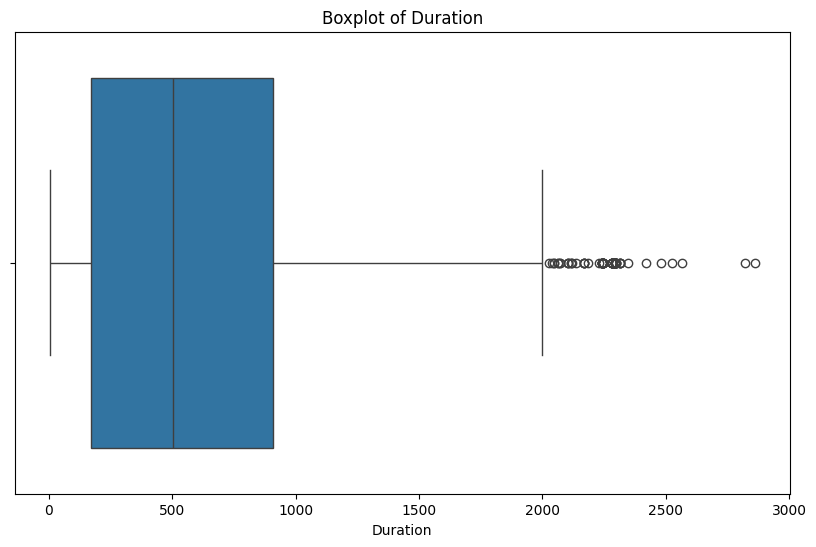

In [139]:
# Vẽ boxplot để phát hiện outlier
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['Duration'])
plt.title('Boxplot of Duration')
plt.show()

In [140]:
# Tìm giá trị Q1, Q3 và IQR của cột 'Duration'
Q1_duration = merged_data['Duration'].quantile(0.25)
Q3_duration = merged_data['Duration'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Xác định ngưỡng cho outlier
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

# Lọc ra các dòng có giá trị 'Duration' là outlier
outliers_duration = merged_data[(merged_data['Duration'] < lower_bound_duration) | (merged_data['Duration'] > upper_bound_duration)]

# Sắp xếp các dòng outlier theo cột 'Duration' từ bé đến lớn
sorted_outliers_duration = outliers_duration.sort_values(by='Duration')

# Hiển thị DataFrame sau khi sắp xếp
sorted_outliers_duration.head(50)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend,Arrival_Date
2747,Air India,2019-03-18,Banglore,New Delhi,BLR → BOM → UDR → DEL,06:45,16:30,2025,2.0,no info,10835,18,34,6,3,Monday,0,2019-03-19
1284,Jet Airways,2019-03-21,Delhi,Cochin,DEL → BDQ → BOM → COK,18:25,04:25,2040,2.0,no info,12347,21,34,18,3,Thursday,0,2019-03-23
8865,Jet Airways,2019-03-21,Delhi,Cochin,DEL → UDR → BOM → COK,18:20,04:25,2045,2.0,no info,13082,21,34,18,3,Thursday,0,2019-03-23
5758,Jet Airways,2019-03-03,Delhi,Cochin,DEL → UDR → BOM → COK,18:20,04:25,2045,2.0,no info,20747,3,34,18,3,Sunday,1,2019-03-05
1112,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,16:15,2065,2.0,no info,10991,1,34,5,5,Wednesday,0,2019-05-02
703,Air India,2019-05-15,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,16:15,2065,2.0,no info,12723,15,34,5,5,Wednesday,0,2019-05-16
3193,Jet Airways,2019-03-06,Delhi,Cochin,DEL → UDR → BOM → COK,17:55,04:25,2070,2.0,in-flight meal not included,15812,6,34,17,3,Wednesday,0,2019-03-08
7322,Jet Airways,2019-03-06,Delhi,Cochin,DEL → UDR → BOM → COK,17:55,04:25,2070,2.0,no info,17072,6,34,17,3,Wednesday,0,2019-03-08
2917,Air India,2019-03-03,Banglore,New Delhi,BLR → CCU → GAU → DEL,11:05,22:10,2105,2.0,no info,11948,3,35,11,3,Sunday,1,2019-03-04
9386,Air India,2019-03-03,Banglore,New Delhi,BLR → CCU → GAU → DEL,11:05,22:10,2105,2.0,no info,11791,3,35,11,3,Sunday,1,2019-03-04


### Xóa dòng đặc biệt ở Duration: có 1 dòng Duration = 5 phút, 1 chuyến bay thì không thể kéo dài 5p được -> xóa.

In [141]:
# Xóa các dòng có giá trị 'Duration' bằng 5
merged_data = merged_data[merged_data['Duration'] != 5]




# **Quan sát và phân tích tập dữ liệu (EDA)**


## 1. Cho biết kiểu dữ liệu của các thuộc tính


In [142]:
# Hiển thị thông tin về DataFrame
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 0 to 10682
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10462 non-null  object        
 1   Date_of_Journey  10462 non-null  datetime64[ns]
 2   Source           10462 non-null  object        
 3   Destination      10462 non-null  object        
 4   Route            10461 non-null  object        
 5   Dep_Time         10462 non-null  object        
 6   Arrival_Time     10462 non-null  object        
 7   Duration         10462 non-null  int64         
 8   Total_Stops      10462 non-null  object        
 9   Additional_Info  10462 non-null  object        
 10  Price            10462 non-null  int64         
 11  Day              10462 non-null  int32         
 12  Duration_Hour    10462 non-null  int32         
 13  Dep_hour         10462 non-null  int32         
 14  Month            10462 non-null  int32     

## 2. Đối với cột Price, cho biết:


*   Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
*   Độ lệch chuẩn của cột price?
*   Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm?
Nhận xét về giá trị mean và median của tập dữ liệu.
*   Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
List item





### 2.1 Code

Giá cao nhất: 79512
Giá thấp nhất: 1759
Giá trung bình: 9025.849072835023
Mức giá xuất hiện nhiều nhất: 10262
Số lần xuất hiện của mức giá: 258
Độ lệch chuẩn của cột Price: 4624.162124562484
Mean: 9025.849072835023, Median: 8266.0
Giá trị mean lớn hơn median, dữ liệu lệch về bên phải.


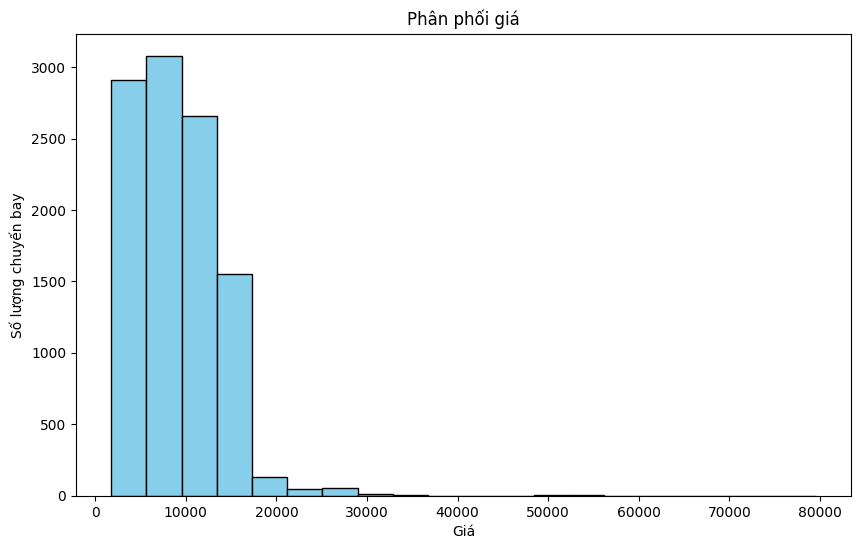

In [143]:
# 1. Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
max_price = merged_data['Price'].max()
min_price = merged_data['Price'].min()
mean_price = merged_data['Price'].mean()
# Đếm số lần xuất hiện của từng giá trị
price_counts = merged_data['Price'].value_counts()
# Lấy giá trị mode (xuất hiện nhiều nhất)
mode_price = price_counts.idxmax()
# Số lần xuất hiện của giá trị mode
mode_count = price_counts.max()


print(f"Giá cao nhất: {max_price}")
print(f"Giá thấp nhất: {min_price}")
print(f"Giá trung bình: {mean_price}")
print(f"Mức giá xuất hiện nhiều nhất: {mode_price}")
print(f"Số lần xuất hiện của mức giá: {mode_count}")

# 2. Độ lệch chuẩn của cột Price
std_price = merged_data['Price'].std()
print(f"Độ lệch chuẩn của cột Price: {std_price}")

# 3. Nhận xét về giá trị mean và median của tập dữ liệu
median_price = merged_data['Price'].median()
print(f"Mean: {mean_price}, Median: {median_price}")
if mean_price > median_price:
    print("Giá trị mean lớn hơn median, dữ liệu lệch về bên phải.")
elif mean_price < median_price:
    print("Giá trị mean nhỏ hơn median, dữ liệu lệch về bên trái.")
else:
    print("Giá trị mean bằng median, phân phối đối xứng.")

# 4. Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Phân phối giá')
plt.xlabel('Giá')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 2.2. Kết luận
#### - Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
- Giá cao nhất: 79512
- Giá thấp nhất: 1759
- Giá trung bình: 9025.849072835023
- Mức giá xuất hiện nhiều nhất: 10262, Số lần xuất hiện của mức giá: 258
#### - Độ lệch chuẩn của cột price?
Độ lệch chuẩn của cột Price: 4624.162124562484

#### - Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm? Nhận xét về giá trị mean và median của tập dữ liệu.
Giá trị mean lớn hơn median, dữ liệu lệch về bên phải. Điều này chứng tỏ có một số giá trị lớn ở phía bên phải của phân phối nghĩa là có các chuyến bay có giá vé cao.
#### - Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
- Phần lớn chuyến bay có giá vé tập trung ở mức giá thấp: Có thể có một số lượng lớn chuyến bay có giá vé thấp, và đây là một đặc điểm chính của dữ liệu.
- Có một số chuyến bay có giá vé cao: Tuy nhiên, cũng có một số chuyến bay có giá vé cao hơn so với giá trung bình, nhưng chúng là ít hơn và tập trung ở khoảng giá trị cao hơn.
- Dữ liệu có độ biến động lớn: Sự chênh lệch giữa giá vé thấp và giá vé cao có thể làm cho phương sai (variance) của dữ liệu lớn.
- Phân phối lệch phải: Nếu phần lớn giá trị tập trung ở giá vé thấp, trong khi một số giá trị cao hơn được giữ lại, thì dữ liệu có thể có sự lệch phải.
- Ưu điểm: Các chuyến bay giá rẻ thường chiếm số lượng lớn, trong khi một số chuyến bay đắt tiền có thể là những trường hợp đặc biệt.

## 3. Mô tả số lượng missing value của mỗi thuộc tính


In [144]:
# 3. Mô tả số lượng missing value của mỗi thuộc tính
missing_values = merged_data.isnull().sum()
print("Số lượng missing value của mỗi thuộc tính:")
print(missing_values)

Số lượng missing value của mỗi thuộc tính:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
Day                0
Duration_Hour      0
Dep_hour           0
Month              0
WeekDay            0
Weekend            0
Arrival_Date       0
dtype: int64


## 4. Tính tỷ lệ % missing value của mỗi thuộc tính


In [145]:
# 4. Tính tỷ lệ % missing value của mỗi thuộc tính
missing_percentage = (missing_values / len(merged_data)) * 100
print("Tỷ lệ % missing value của mỗi thuộc tính:")
print(missing_percentage)

Tỷ lệ % missing value của mỗi thuộc tính:
Airline            0.000000
Date_of_Journey    0.000000
Source             0.000000
Destination        0.000000
Route              0.009558
Dep_Time           0.000000
Arrival_Time       0.000000
Duration           0.000000
Total_Stops        0.000000
Additional_Info    0.000000
Price              0.000000
Day                0.000000
Duration_Hour      0.000000
Dep_hour           0.000000
Month              0.000000
WeekDay            0.000000
Weekend            0.000000
Arrival_Date       0.000000
dtype: float64


## 5. Xử lý dữ liệu missing


In [146]:
# 5. Xử lý dữ liệu missing ( xóa các dòng có missing value)
merged_data.dropna(subset=['Total_Stops'], inplace=True)
# drop null values
merged_data.dropna(axis=0, subset=['Total_Stops', 'Route'], inplace=True)
# reset indexes
merged_data.reset_index(inplace=True)
merged_data.drop(['index'], axis=1, inplace=True)

## 6. Outlier: sử dụng đồ thị boxplot để quan sát cột Price có tồn tại outlier không?

### Đồ thị

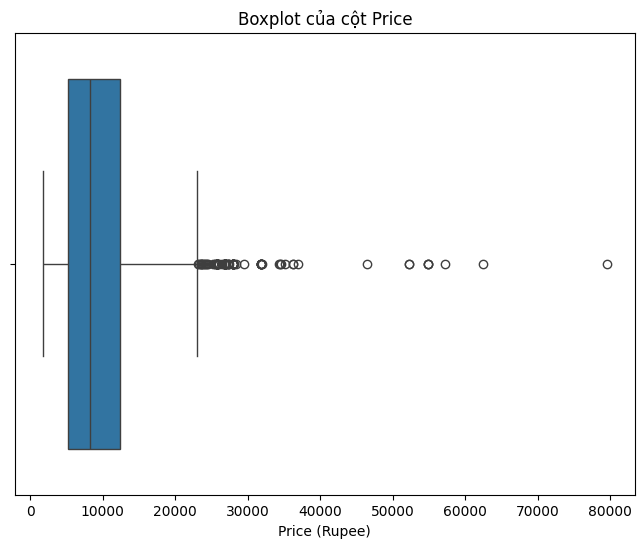

In [147]:
# Vẽ boxplot cho cột Price trong merged_data
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_data['Price'])
plt.title('Boxplot của cột Price')
plt.xlabel('Price (Rupee)')  # Thêm đơn vị cho trục x
plt.show()

### Các giá trị outlier: các giá trị outlier là có tồn tại, tuy nhiên có các chuyến bay giá cao như vậy có thể là do thời gian bay dài (Duration), hạng vé business/premium (Airline)




In [148]:
# Xác định giá trị Q1, Q3 và IQR
Q1 = merged_data['Price'].quantile(0.25)
Q3 = merged_data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng cho outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc ra các dòng có giá trị 'Price' là outlier
outliers = merged_data[(merged_data['Price'] < lower_bound) | (merged_data['Price'] > upper_bound)]

# Hiển thị các dòng có giá 'Price' là outlier
print("Các dòng có giá 'Price' là outlier:")
outliers


Các dòng có giá 'Price' là outlier:


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend,Arrival_Date
123,Air India,2019-03-01,Delhi,Cochin,DEL → BOM → COK,23:00,19:15,1215,1.0,no info,27430,1,20,23,3,Friday,0,2019-03-02
396,Multiple carriers,2019-03-01,Delhi,Cochin,DEL → BOM → COK,12:50,19:15,385,1.0,no info,36983,1,6,12,3,Friday,0,2019-03-01
627,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,07:40,885,1.0,1 long layover,26890,1,15,16,3,Friday,0,2019-03-02
688,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,10:25,1050,1.0,1 long layover,25735,1,18,16,3,Friday,0,2019-03-02
750,Jet Airways,2019-03-18,Banglore,New Delhi,BLR → BOM → DEL,22:50,05:05,375,1.0,no info,54826,18,6,22,3,Monday,0,2019-03-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,11:40,18:25,405,1.0,no info,26890,1,7,11,3,Friday,0,2019-03-01
10106,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,08:15,920,1.0,no info,26890,1,15,16,3,Friday,0,2019-03-02
10238,Air India,2019-03-01,Banglore,New Delhi,BLR → BOM → BHO → DEL,08:50,09:25,1475,2.0,no info,25430,1,25,8,3,Friday,0,2019-03-02
10279,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,14:05,19:10,305,1.0,no info,36235,1,5,14,3,Friday,0,2019-03-01


# **Visualize dữ liệu dạng bảng hoặc đồ thị**

## 1. Giá vé tăng khi nào?

### Kiểm tra giá vé máy bay có thay đổi khi hãng hàng không thay đổi.
Lí do chọn đồ thị: Đồ thị cột giúp dễ dàng so sánh giá trung bình giữa các hãng máy bay. Những cột cao hơn sẽ nhanh chóng thu hút sự chú ý và làm cho so sánh trở nên rõ ràng.

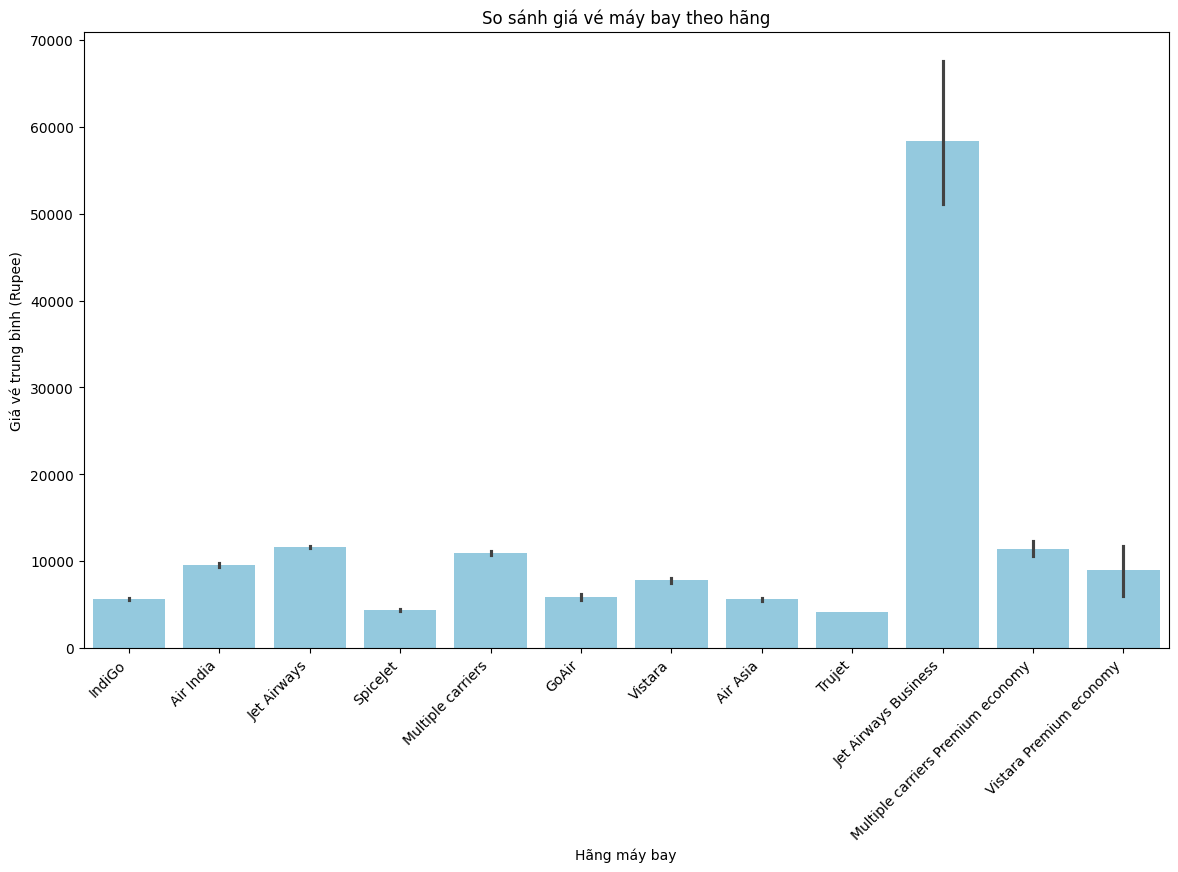

In [149]:
# Biểu đồ cột: Giá vé trung bình của từng hãng máy bay
plt.figure(figsize=(14, 8))
sns.barplot(x='Airline', y='Price', data=merged_data, estimator=np.mean, color='skyblue')
plt.title('So sánh giá vé máy bay theo hãng')
plt.xlabel('Hãng máy bay')
plt.ylabel('Giá vé trung bình (Rupee)')
plt.xticks(rotation=45, ha='right')
plt.show()



### Kiểm tra giá vé máy bay có tăng khi Total_Stops thay đổi
Lí do chọn đồ thị: Hiển thị tổng quan:
- Biểu đồ cột giúp hiển thị mối quan hệ giữa Total_Stops và giá vé máy bay một cách tổng quan. Ta có thể nhanh chóng nhận thức được sự thay đổi giá theo số lượng stops.
- Dễ so sánh: Các cột có thể dễ dàng so sánh giá trung bình giữa các nhóm Total_Stops. Nếu có sự chênh lệch lớn, nó sẽ rõ ràng trên biểu đồ.

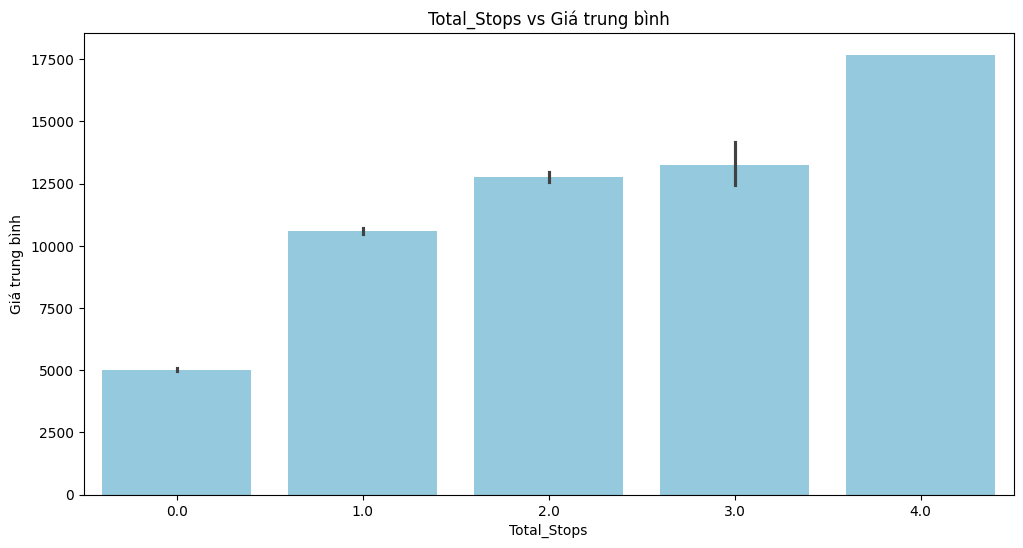

In [150]:

# Biểu đồ : Total_Stops vs Giá trung bình
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Stops', y='Price', data=merged_data, color='skyblue')
plt.title('Total_Stops vs Giá trung bình')
plt.xlabel('Total_Stops')
plt.ylabel('Giá trung bình')
plt.show()


### Kiểm tra giá vé có thay đổi khi Duration thay đổi.
Lí do chọn biểu đồ này:
- Mối Quan Hệ Liên Tục: Với khoảng 50 giá trị Duration_Hour, biểu đồ đường phản ánh mối quan hệ liên tục, hữu ích khi chúng ta muốn xem xét cách giá vé phản ánh sự biến thiên của thời gian chuyến bay.
- Dễ Theo Dõi Tăng Giảm: Nếu có sự tăng giảm đột ngột hoặc xu hướng rõ ràng, biểu đồ đường sẽ làm cho điều này rõ ràng hơn so với bảng dữ liệu.

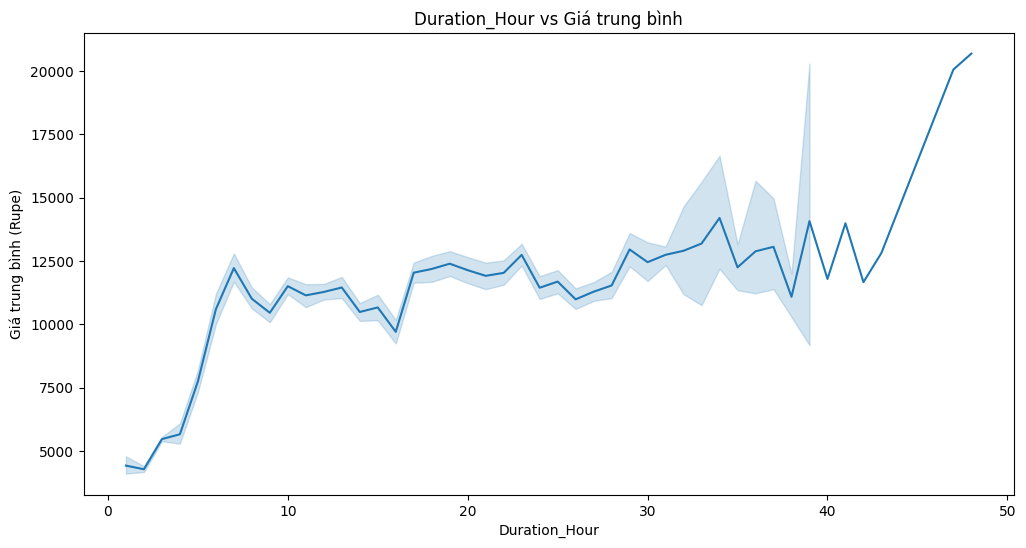

In [151]:
# Biểu đồ đường: Duration_Hour vs Giá trung bình
plt.figure(figsize=(12, 6))
sns.lineplot(x='Duration_Hour', y='Price', data=merged_data)
plt.title('Duration_Hour vs Giá trung bình')
plt.xlabel('Duration_Hour')
plt.ylabel('Giá trung bình (Rupe)')
plt.show()


### Kiểm tra giá vé có thay đổi khi giờ bay Dep_hour thay đổi
Lí do chọn biểu đồ này: dễ quan sát và so sánh: Sử dụng biểu đồ đường giúp dễ dàng so sánh giá vé giữa các giờ khác nhau và nhận biết sự khác biệt.

C:\Users\Vanniee\AppData\Local\Temp\ipykernel_23332\1161882445.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Dep_hour', y='Price', data=merged_data, palette='viridis')


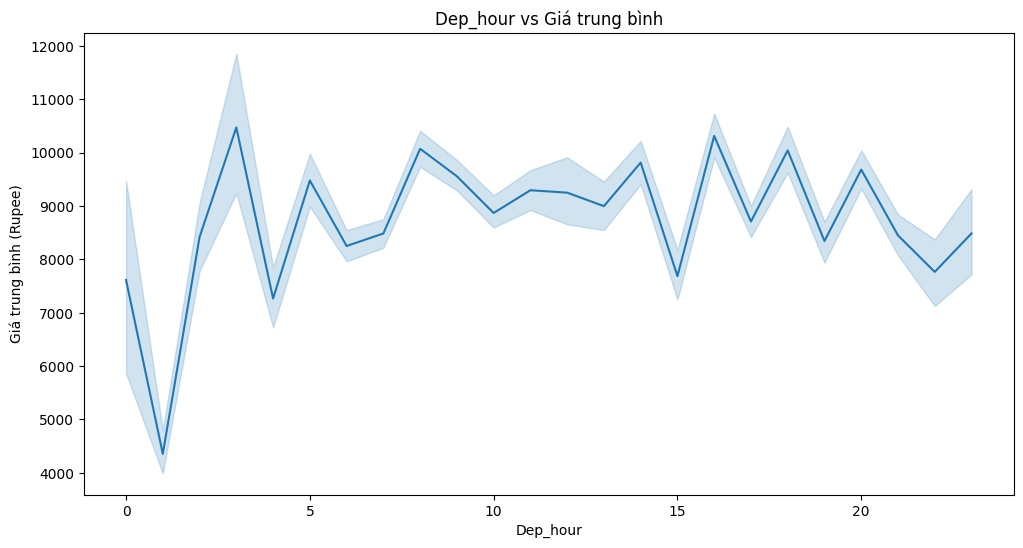

In [152]:
# Biểu đồ : Dep_hour vs Giá trung bình
plt.figure(figsize=(12, 6))
sns.lineplot(x='Dep_hour', y='Price', data=merged_data, palette='viridis')
plt.title('Dep_hour vs Giá trung bình')
plt.xlabel('Dep_hour')
plt.ylabel('Giá trung bình (Rupee)')
plt.show()


### Kết luận:
 Dựa vào thực tế, giá vé máy bay thường phụ thuộc vào hãng hàng  không (Airline) , số điểm dừng (Total_Stop), Thời gian bay (Duration_hour), Giờ bay trong 1 ngày, ... Nên em vẽ biểu đồ để kiểm tra và có thể kết luận được rằng giá vé máy bay tăng khi:
- Khi chọn hãng hàng không khác nhau, ví dụ chọn Jet Airways Business
- Khi số điểm dừng (Total_stop) tăng.
- Khi thời gian bay tăng (Duration_hour).

(Với giờ bay trong 1 ngày thì chúng chỉ có thể kết luận là 1 giờ sáng là thời gian vé rẻ nhất trong ngày)


## 2. So sánh tỷ lệ các chuyến bay thẳng và trung chuyển (có dừng)

### 2.1. Visualize
Bởi vì cần đưa ra sự so sánh tỷ lệ giữa 2 chuyến bay thẳng và trung chuyển nên chọn biểu đồ tròn, thể hiện trực quan tỉ lệ. Thêm 1 biểu đồ cột phụ để thể hiện số lượng từng loại chuyến bay theo điểm dừng

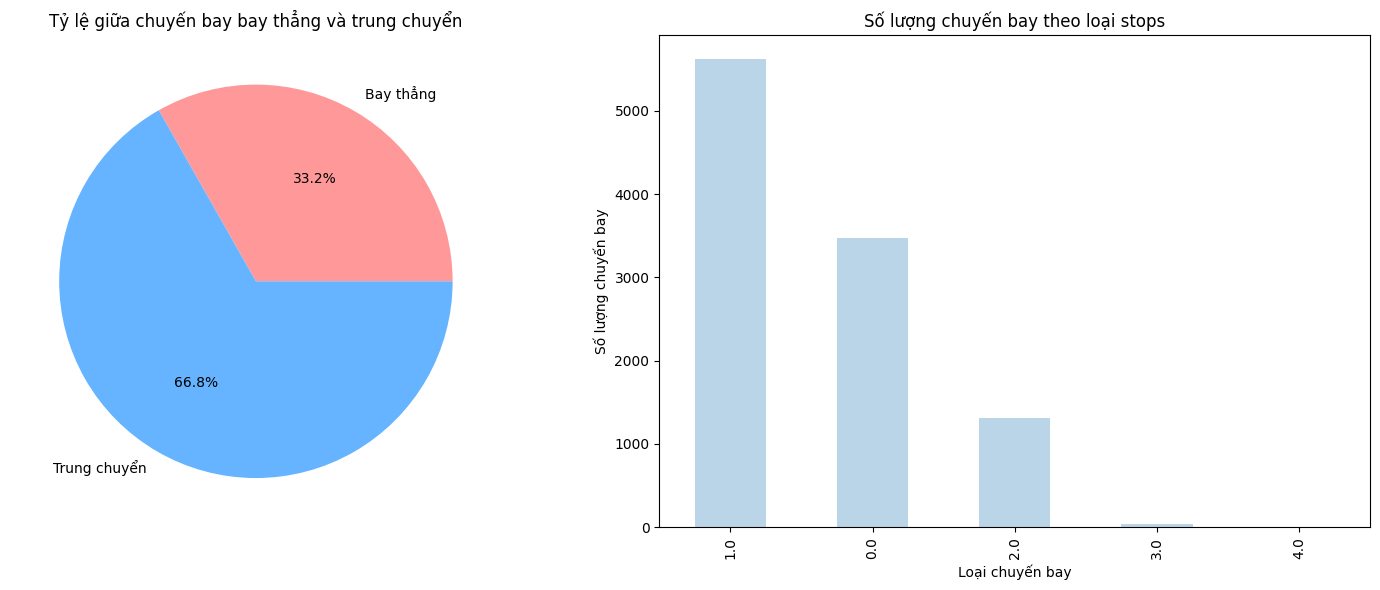

In [153]:
# Tạo DataFrame
data = pd.DataFrame(merged_data)

# Tính tỷ lệ giữa chuyến bay non-stop và chuyến bay có stops
stops_counts = data['Total_Stops'].value_counts()

# Tạo DataFrame mới chỉ chứa thông tin non-stop và stops
stops_data = pd.DataFrame({
    'Bay thẳng': stops_counts[0],
    'Trung chuyển': stops_counts.sum() - stops_counts[0]
}, index=[0])

# Vẽ biểu đồ
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Biểu đồ tròn cho tỷ lệ stops
colors_pie = ['#ff9999', '#66b3ff']  # Đổi màu ở đây
axes[0].pie(stops_data.iloc[0], labels=stops_data.columns, autopct='%1.1f%%', colors=colors_pie)
axes[0].set_title('Tỷ lệ giữa chuyến bay bay thẳng và trung chuyển')

# Biểu đồ cho tỷ lệ stops_counts
stops_counts.plot(kind='bar', alpha=0.3, ax=axes[1])
axes[1].set_title('Số lượng chuyến bay theo loại stops')
axes[1].set_xlabel('Loại chuyến bay')
axes[1].set_ylabel('Số lượng chuyến bay')

plt.tight_layout()
plt.show()

 ### **2.2 Kết luận:**
- Các chuyến bay trung chuyển nhiều gấp đôi những chuyến bay thẳng, đa số là một điểm dừng và ít hơn là 2 điểm dừng, từ 3 tới 4 là rất ít


## 3. Nước nào có lượng chuyến bay nhiều nhất?

### 3.1. Visualize
 Bởi vì cần đưa ra sự so sánh giữa các nhóm (các thành phố) nên chọn biểu đồ cột là trực quan hơn, giúp người xem dễ hiểu hơn. Và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý.

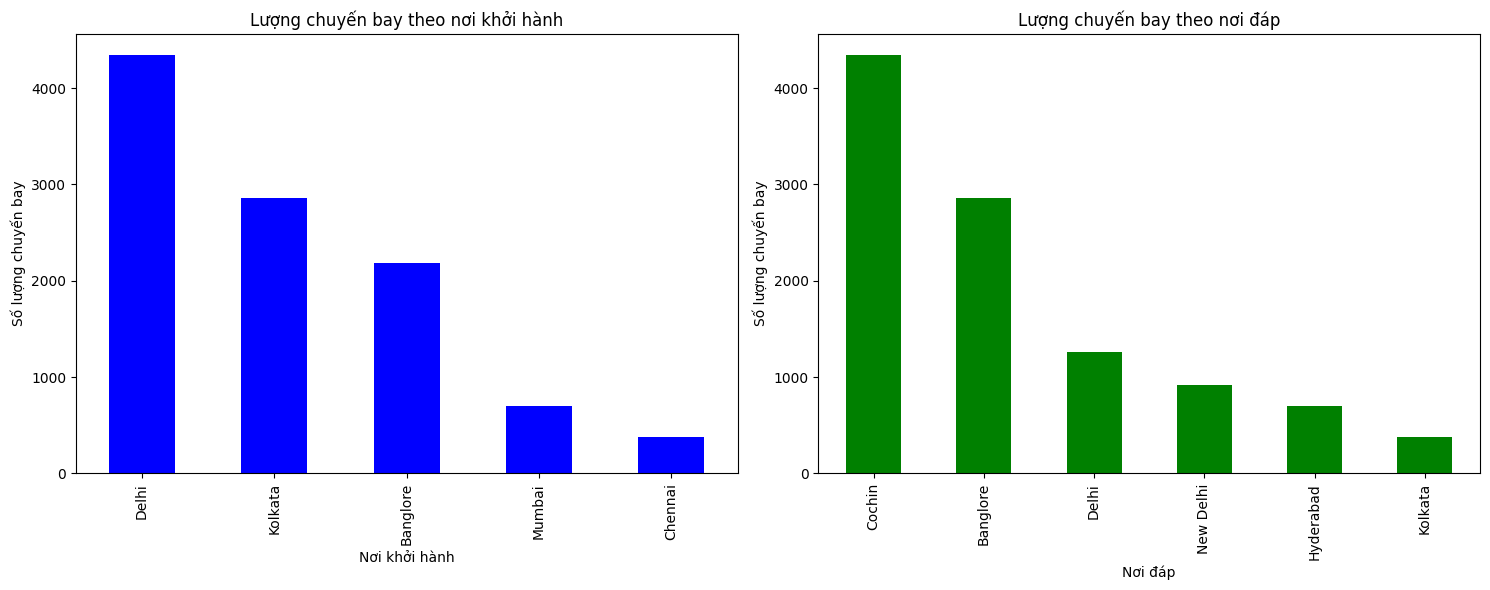

In [154]:
# Tạo DataFrame
data = pd.DataFrame(merged_data)

# Tạo subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Biểu đồ theo nơi khởi hành
flight_count_by_source = data['Source'].value_counts()
flight_count_by_source.plot(kind='bar', color='blue', ax=axes[0])
axes[0].set_title('Lượng chuyến bay theo nơi khởi hành')
axes[0].set_xlabel('Nơi khởi hành')
axes[0].set_ylabel('Số lượng chuyến bay')

# Biểu đồ theo nơi đáp
flight_count_by_destination = data['Destination'].value_counts()
flight_count_by_destination.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Lượng chuyến bay theo nơi đáp')
axes[1].set_xlabel('Nơi đáp')
axes[1].set_ylabel('Số lượng chuyến bay')

plt.tight_layout()
plt.show()

### **3.2 Nhận xét:**
- Xét theo nơi khởi hành thì Delhi là thành phố có nhiều chuyến bay đi nhất.
- Xét theo nơi đáp thì Cochin là thành phố có nhiều chuyến bay đáp đến nhất.


## 4. Hãng máy bay nào được khách đặt vé nhiều/thấp nhất?

### 4.1 Visualize: Bởi vì cần đưa ra sự so sánh giữa các nhóm (các hãng mới bay) nên chọn biểu đồ là trực quan hơn, giúp người xem dễ hiểu hơn. Và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý. Trên mỗi cột có hiển thị số lượng chuyến bay vì có những hãng có số chuyến bay quá nhỏ ví dụ 1, 3, hoặc 6 so với những hãng lên đến cả nghìn chuyến bay thì rất khó để biết số lượng.

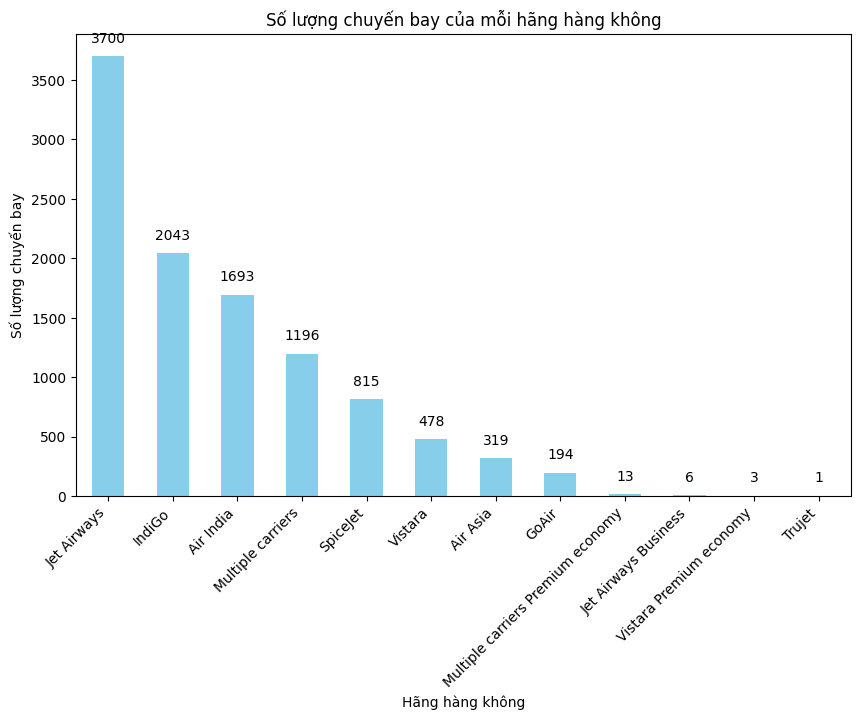

In [155]:
# Đếm số lượng chuyến bay của từng hãng hàng không
airline_counts = merged_data['Airline'].value_counts()

# Vẽ đồ thị cột
plt.figure(figsize=(10, 6))
ax = airline_counts.plot(kind='bar', color='skyblue')

# Thêm số lượng chuyến bay trên đầu mỗi cột
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', xytext=(0, 10), textcoords='offset points')

# Đặt tên hãng máy bay chéo 45 độ
plt.xticks(rotation=45, ha='right')

plt.title('Số lượng chuyến bay của mỗi hãng hàng không')
plt.xlabel('Hãng hàng không')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 4.2. Kết luận
#### - Dựa vào thông tin datasets cung cấp thì không thể biết được hãng nào được khách đặt nhiều nhất, hay ít nhất; ví dụ: Hãng Jet Airways có 3700 chuyến nhưng mỗi chuyến chỉ có 50 khách đặt-> tổng là 185.000, còn hãng IndiGo có 2043 nhưng mỗi chuyến có 100 khách đăt -> tổng là 204300 lượt khách, mà 204300> 185000, nên IndiGo có lượng khách đặt nhiều hơn Jet Airways dù IndiGo có ít chuyến bay hơn. **Như vậy, với datasets được cung cấp và qua số lượng chuyến bay của mỗi hãng, thì không thể kết luận được hãng nào nhiều/ít khách đặt nhất. Cần có thêm 1 cột Số lượng hành khách mỗi chuyến bay thì ta mới có thể xác định được.**
#### -  Với trường hợp, số lượng khách đặt mỗi chuyến là như nhau (hay chênh lệch không đáng kể), thì hãng Jet Airways có nhiều khách đặt nhất và Trujet có ít khách đặt nhất


## 5. Tháng nào là tháng cao điểm

### 5.1. Visualize: 
Bởi vì cần đưa ra sự so sánh giữa các nhóm (các tháng) nên chọn biểu đồ là trực quan hơn, giúp người xem dễ hiểu hơn. Vì dữ liệu có ít nhóm (chỉ có số liệu của 4 tháng trong năm 2019) và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý.

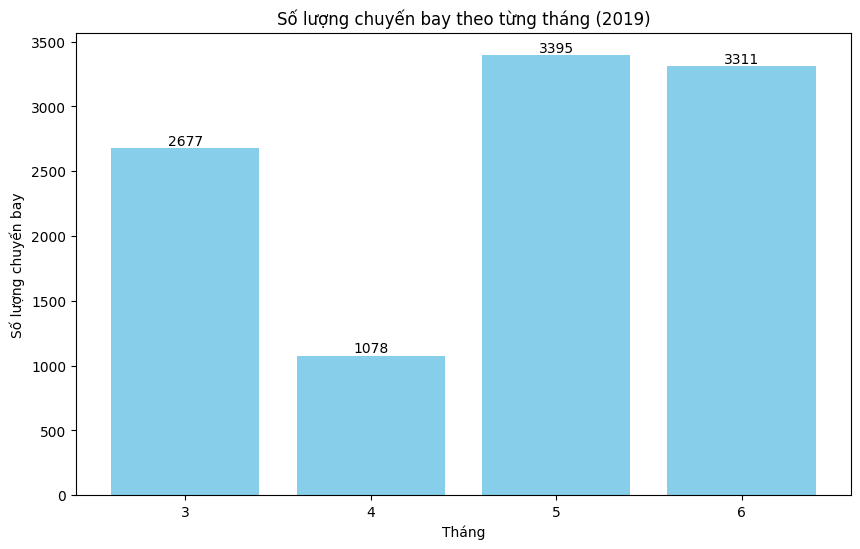

In [156]:
# Đếm số lượng chuyến bay của từng tháng
monthly_flight_counts = merged_data['Month'].value_counts().sort_index()

# Vẽ đồ thị cột
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_flight_counts.index, monthly_flight_counts, color='skyblue')

# Thêm chú thích (annotation) trên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, int(yval), int(yval), ha='center', va='bottom')

# Xoay số tháng thẳng lên
plt.xticks(rotation=0)

# Chỉ hiển thị các tháng duy nhất trên trục x
plt.xticks(monthly_flight_counts.index)

plt.title('Số lượng chuyến bay theo từng tháng (2019)')
plt.xlabel('Tháng')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 5.2. Kết luận
#### Tháng 5 và tháng 6 là 2 tháng số lượng chuyến bay nhiều nhất (số lượng tháng 6 xấp xỉ tháng tháng 5). Như vậy có thể đưa ra kết luận, tháng 5 là tháng cao điểm.


## 6. Giá có thay đổi tùy theo hãng hàng không hay không?

### 6.1. Visualize:
Biểu đồ cột là một lựa chọn tốt để visualize dữ liệu này vì nó cho phép người dùng so sánh trực quan các mức giá khác nhau. Biểu đồ cũng hiển thị dữ liệu theo loại chuyến bay, cho phép người dùng thấy sự khác biệt về giá vé giữa các loại chuyến bay.

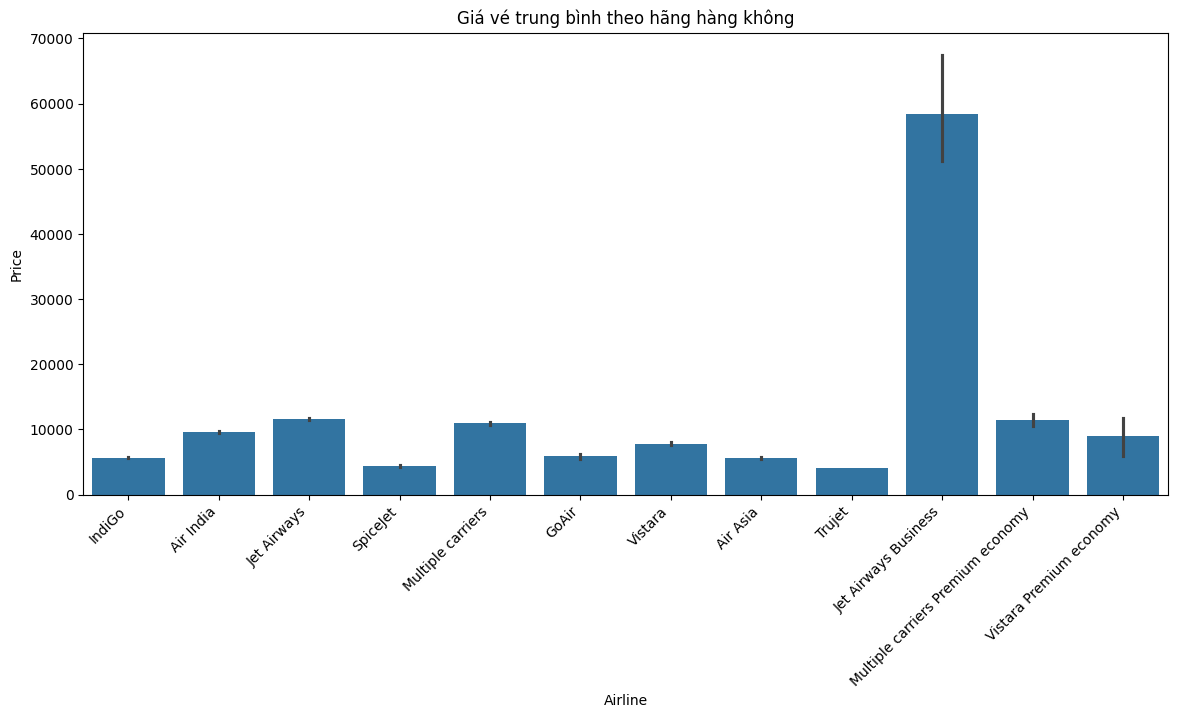

In [157]:
avg_price_by_airline = merged_data.groupby('Airline')['Price'].mean().sort_values()
plt.figure(figsize=(14, 6))
sns.barplot(x='Airline', y='Price', data=merged_data)
plt.xticks(rotation=45, ha='right')
plt.title('Giá vé trung bình theo hãng hàng không')
plt.show()

In [158]:
# Tính toán thông số thống kê cho giá vé theo từng hãng hàng không
average_price_by_airline = merged_data.groupby('Airline')['Price'].mean()
median_price_by_airline = merged_data.groupby('Airline')['Price'].median()
std_price_by_airline = merged_data.groupby('Airline')['Price'].std()

# Tạo DataFrame từ các Series thống kê
stats_df = pd.DataFrame({
    'Trung bình': average_price_by_airline,
    'Trung vị': median_price_by_airline,
    'Độ lệch chuẩn': std_price_by_airline
})

# In bảng thống kê
print("Thống kê giá vé theo hãng hàng không:")
print(stats_df)


Thống kê giá vé theo hãng hàng không:
                                     Trung bình  Trung vị  Độ lệch chuẩn
Airline                                                                 
Air Asia                            5590.260188    5162.0    2027.362290
Air India                           9552.018311    9292.0    3934.504195
GoAir                               5861.056701    5135.0    2703.585767
IndiGo                              5668.469897    5000.0    2266.933697
Jet Airways                        11599.021081   11134.0    4315.671402
Jet Airways Business               58358.666667   54747.0   11667.596748
Multiple carriers                  10902.678094   10197.0    3721.234997
Multiple carriers Premium economy  11418.846154   11269.0    1717.153936
SpiceJet                            4335.841718    3873.0    1851.144678
Trujet                              4140.000000    4140.0            NaN
Vistara                             7801.355649    7980.0    2915.288625
Vistara Premi

### 6.2. Kết luận: 
Dựa vào biểu đồ và  thống kê giá vé trung bình theo từng hãng hàng không, có thể rút ra kết luận rằng **Giá vé có thay đổi tùy theo hãng hàng không**:
- Có sự chênh lệch đáng kể giữa các hãng hàng không.
- Jet Airways Business có giá vé trung bình cao nhất, trong khi SpiceJet có giá thấp nhất.



## 7. Giá vé bị ảnh hưởng như thế nào khi mua vé chỉ 1 hoặc 2 ngày trước ngày khởi hành?

### 7.1.  Visualize
Bởi vì có nhiều nhóm (thời gian, source-des) cần so sánh sự thay đổi, và cần xem xét xu hướng tăng giảm của giá nên chọn biểu đồ đường.

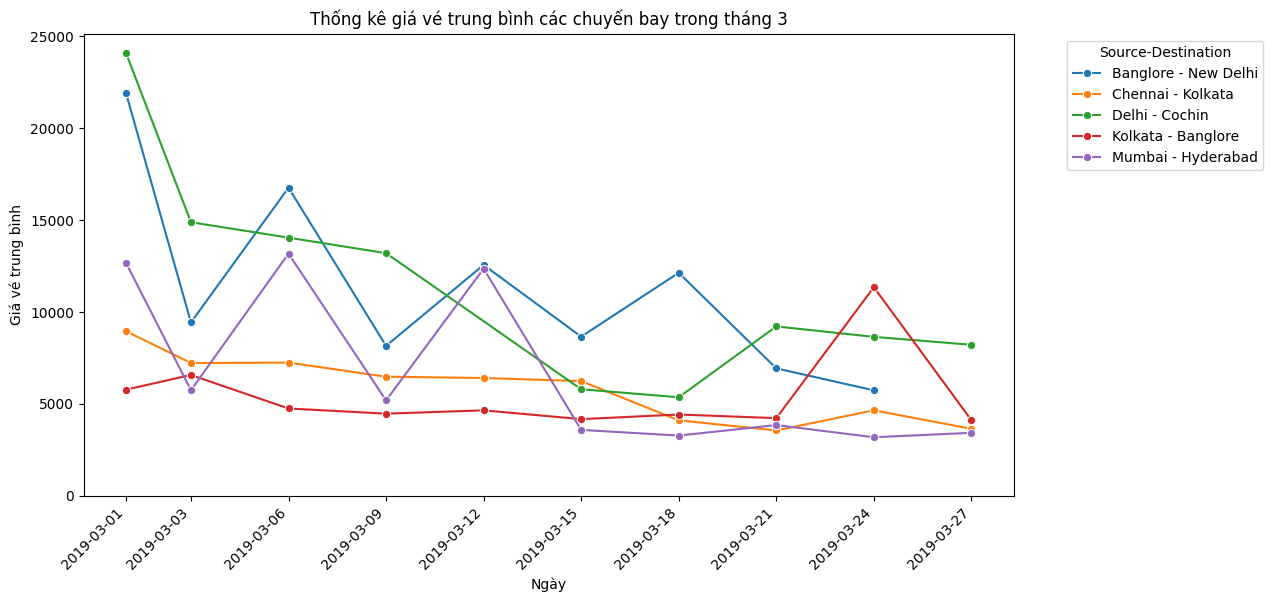

In [159]:
# Assuming you have a sorted list of unique months
#unique_month_sorted = merged_data['Month'].sort_values().unique()

month = 3
# Loop through each month to create a line plot
#for month in unique_month_sorted:
    # Filter data for the current month
data_month = merged_data[merged_data['Month'] == month]
    
# Group by source, destination, and date to calculate average price for each pair over time
average_price = data_month.groupby(['Source', 'Destination', 'Date_of_Journey'])['Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
# Concatenate 'Source' and 'Destination' to create a new column
average_price['Source-Destination'] = average_price['Source'] + ' - ' + average_price['Destination']

# Use Seaborn's lineplot to plot the average price over time for each source-destination pair
sns.lineplot(x='Date_of_Journey', y='Price', hue='Source-Destination', data=average_price,marker='o')

plt.ylim(0)
plt.xlabel('Ngày')
plt.ylabel('Giá vé trung bình')
plt.title(f'Thống kê giá vé trung bình các chuyến bay trong tháng {month}')
plt.xticks(data_month['Date_of_Journey'].unique(), rotation=45, ha='right')
plt.legend(title='Source-Destination', bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.show()

### **7.2. Kết luận:**

- Giá vé chuyến bay tháng 3:
	+ Chennai - Kolkata không có sự chênh lệch lớn.
	+ Delhi - Cochin giá ngày 1 cao hơn ~gấp đôi so mặt bằng chung, trong khi ngày 15, 18 thì thấp hơn.
	+ Banglore - New Delhi giá vé có sự lên xuống giữa các ngày gần nhau, riêng giá ngày 1 cao hơn.
	+ Mumbai - Hyderabad: Đầu tháng giá vé có sự chênh lệch, về cuối tháng thấp hơn so với mặt bằng chung.
	+ Kolkata - Banglore: ngày 24 giá vé cao hơn so với cả tháng.
- Giá vé chuyến bay tháng 4:
	+ Delhi - Cochin giá ngày 9 cao hơn so với cả tháng.
	+ Banglore - New Delhi không có sự chênh lệch lớn.
	+ Mumbai - Hyderabad: không có sự chênh lệch lớn.
	+ Kolkata - Banglore: ngày 1 giá vé cao hơn so với cả tháng.
- Giá vé chuyến bay tháng 5:
	+ Chennai - Kolkata, Banglore - Delhi, Mumbai - Hyderabad không có sự chênh lệch lớn.
	+ Delhi - Cochin: giá cả tháng cao, riêng ngày 12 thấp. 
	+ Kolkata - Banglore: giá cả tháng cao, riêng ngày 3, 27 thấp.
- Giá vé chuyến bay tháng 6:
	+ Chennai - Kolkata, Banglore - Delhi, Mumbai - Hyderabad không có sự chênh lệch lớn.
	+ Delhi - Cochin: giá cả tháng cao, riêng ngày 18, 21 thấp. 
	+ Kolkata - Banglore: giá ngày 6, 9, 12 cao. 
    
*Vậy giá vé có sự chênh lệch giữa các ngày và các địa điểm đi và đến trong tháng*


## 8. Giá vé có thay đổi theo thời gian đi và đến không?

### 8.1.  Visualize
Bởi vì có nhiều nhóm (thời gian 0-23) cần so sánh sự thay đổi, và cần xem xét xu hướng tăng giảm của giá nên chọn biểu đồ đường.

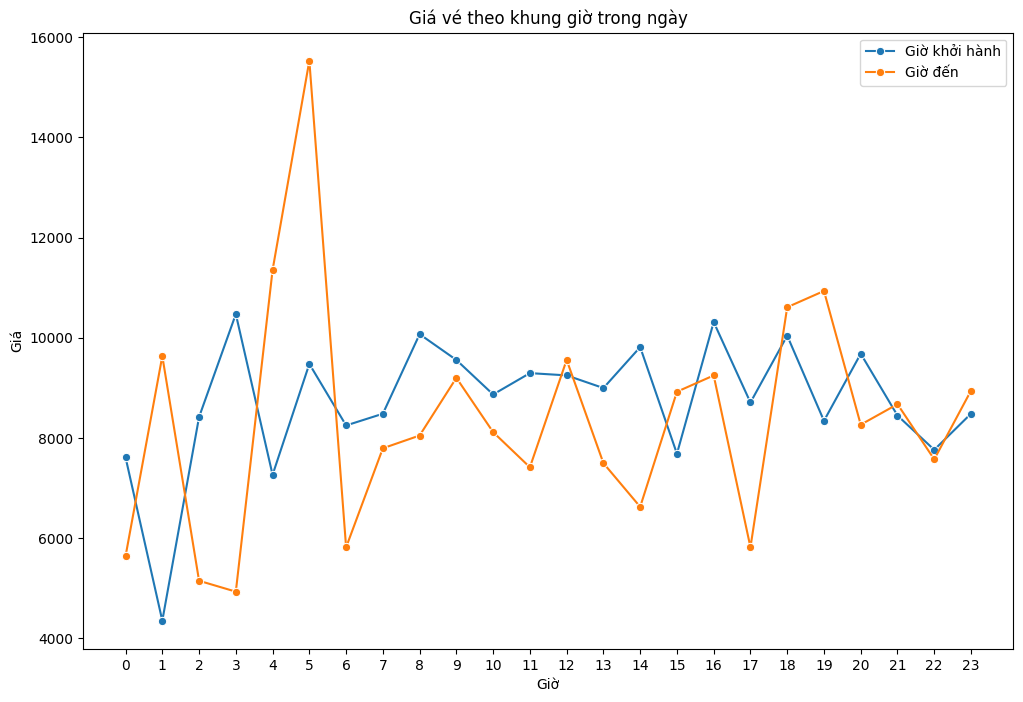

In [160]:
merged_data['Departure_Hour'] = pd.to_datetime(merged_data['Dep_Time'], format='%H:%M').dt.hour
# Convert Arrival_Time to datetime
merged_data['Arrival_Hour'] = pd.to_datetime(merged_data['Arrival_Time'], format='%H:%M').dt.hour
# Concatenate 'Departure_Hour' and 'Arrival_Hour' columns
all_hours = pd.concat([merged_data['Departure_Hour'], merged_data['Arrival_Hour']])

# Create a new figure with Matplotlib
plt.figure(figsize=(12, 8))

# Use Seaborn to plot the line for Departure_Hour
sns.lineplot(x='Departure_Hour', y='Price', data=merged_data, marker='o', label='Giờ khởi hành', errorbar=None)
# Use Seaborn to plot the line for Arrival_Hour
sns.lineplot(x='Arrival_Hour', y='Price', data=merged_data, marker='o', label='Giờ đến', errorbar=None)
# Set labels and title
plt.xlabel('Giờ')
plt.ylabel('Giá')
plt.title('Giá vé theo khung giờ trong ngày')
plt.legend()  # Show legend with labels for each line

# Customize x-axis ticks
plt.xticks(sorted(all_hours.unique()))  # Use unique hours for ticks and sort them

# Show the plot
plt.show()

### **8.2. Kết luận:**

- Giá vé có sự chênh lệch giữa thời gian đi và đến trong ngày.
    + Với thời gian đi: Lúc 1h sáng giá rớt rất thấp sau tăng vọt và có sự chênh lệch nhẹ với các khung giờ còn lại.
    + Với thời gian đến: Giá thấp nhất rơi vào khoảng 2h, 3h sáng và cao nhất lúc 5h sáng, các khung giờ còn lại có sự chênh lệch.

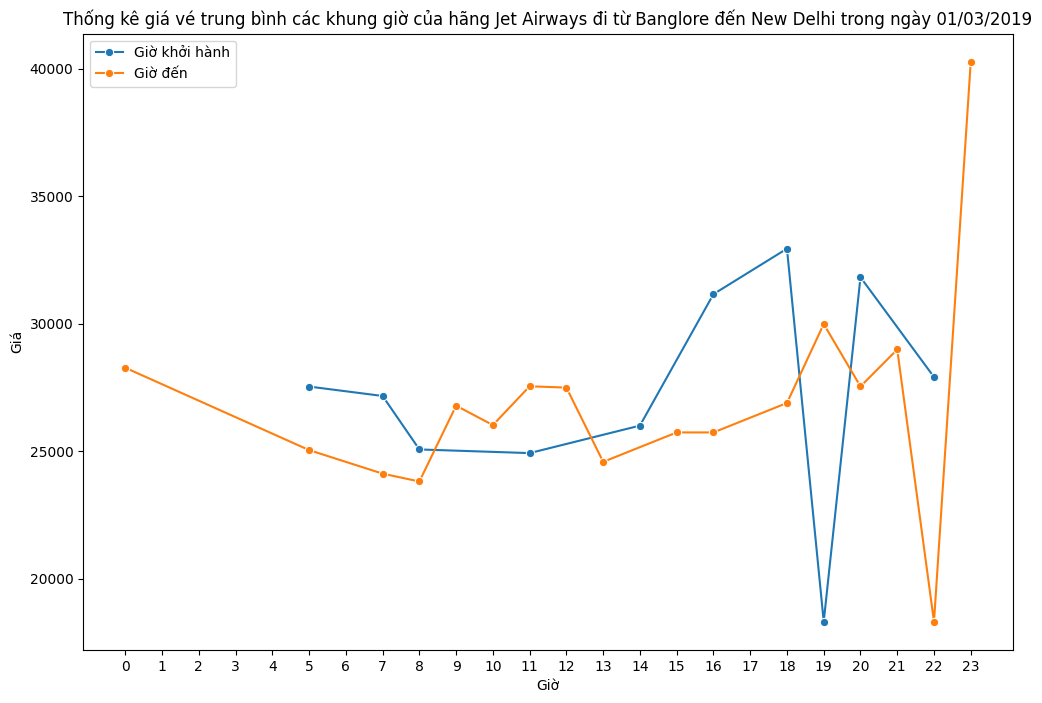

In [161]:
# ReplReplace 'Jet Airways' with the desired airline
airline = 'Jet Airways'
# Replace '01/05/2019' with the specific date you want to filter
specific_date = '01/03/2019'
specific_date = pd.to_datetime(specific_date, format='%d/%m/%Y')
day = specific_date.strftime('%d/%m/%Y')
source = 'Banglore'
des = 'New Delhi'
# Filter data for the specific airline and specific date
filtered_data = merged_data[
    (merged_data['Airline'] == airline) & 
                            (merged_data['Date_of_Journey'] == specific_date) 
                            & (merged_data['Source'] == source)
                     & (merged_data['Destination'] == des)
                            ]
# Concatenate 'Departure_Hour' and 'Arrival_Hour' columns
all_hours = pd.concat([merged_data['Departure_Hour'], merged_data['Arrival_Hour']])

# Create a new figure with Matplotlib
plt.figure(figsize=(12, 8))

# Use Seaborn to plot the line for Departure_Hour
sns.lineplot(x='Departure_Hour', y='Price', data=filtered_data, marker='o', label='Giờ khởi hành', errorbar=None)
# Use Seaborn to plot the line for Arrival_Hour
sns.lineplot(x='Arrival_Hour', y='Price', data=filtered_data, marker='o', label='Giờ đến', errorbar=None)
# Set labels and title
plt.xlabel('Giờ')
plt.ylabel('Giá')
plt.title(f'Thống kê giá vé trung bình các khung giờ của hãng {airline} đi từ {source} đến {des} trong ngày {day}')
plt.legend()  # Show legend with labels for each line

# Customize x-axis ticks
plt.xticks(sorted(all_hours.unique()))  # Use unique hours for ticks and sort them

# Show the plot
plt.show()

### **8.3. Nhận xét:**

- Giá vé theo thời gian đi và đến cho chi tiết của hãng Jet Airways đi từ 'Banglore' đến 'New Delhi' trong ngày '01/03/2019' có sự chênh lệch.


## 9. Giá thay đổi như thế nào khi thay đổi Nguồn và Điểm đến?

## 9.1. Visualize
Biểu đồ cột là một phương tiện trực quan và hiệu quả để so sánh giá vé trung bình giữa các cặp Nguồn và Điểm đến. Chiều cao của cột dễ dàng so sánh, giúp hiển thị sự chênh lệch giá một cách rõ ràng

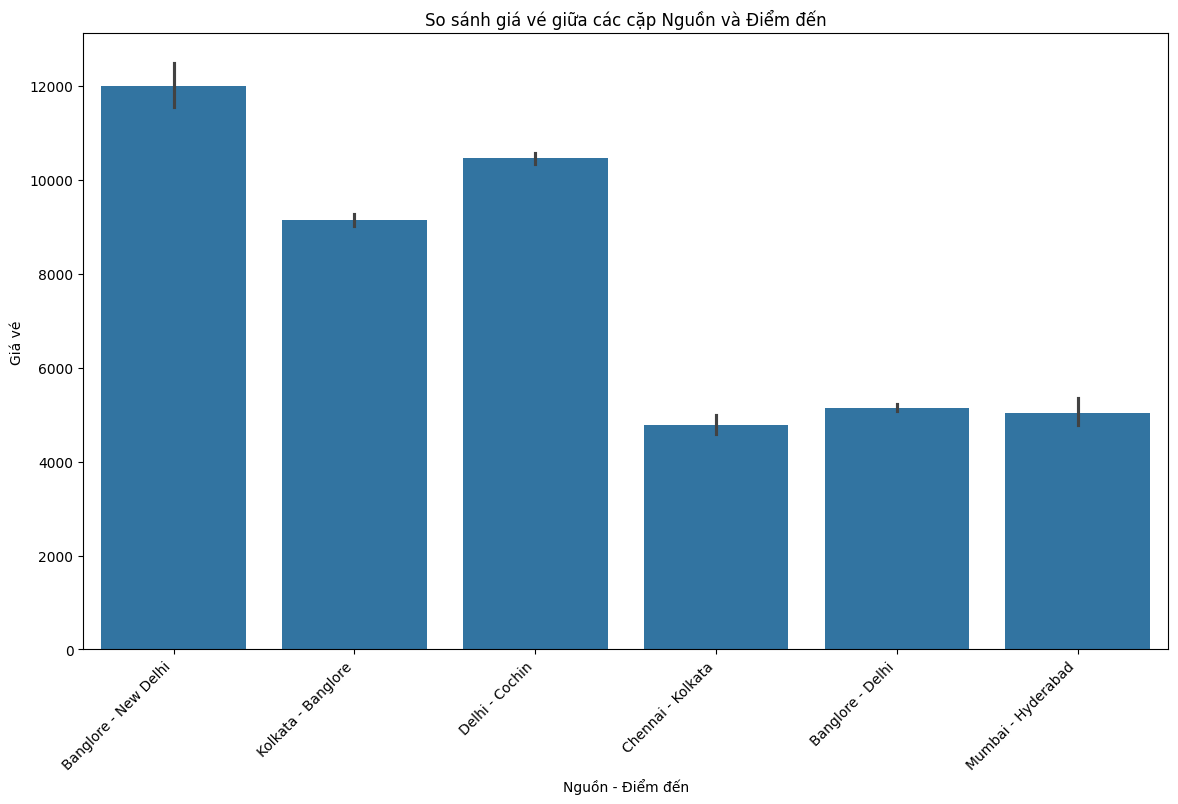

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ cột so sánh giá vé trung bình giữa các cặp Nguồn và Điểm đến
plt.figure(figsize=(14, 8))
sns.barplot(x=merged_data['Source'] + ' - ' + merged_data['Destination'], y=merged_data['Price'])
plt.xlabel('Nguồn - Điểm đến')
plt.ylabel('Giá vé')
plt.title('So sánh giá vé giữa các cặp Nguồn và Điểm đến')
plt.xticks(rotation=45, ha='right')
plt.show()


In [194]:
average_price_by_route = merged_data.groupby(['Source', 'Destination'])['Price'].mean()
std_price_by_route = merged_data.groupby(['Source', 'Destination'])['Price'].std()

# Tạo DataFrame từ các Series thống kê
stats_by_route_df = pd.DataFrame({
    'Trung bình giá vé': average_price_by_route,
    'Độ lệch chuẩn giá vé': std_price_by_route
})

# In bảng thống kê
print("Thống kê giá vé theo Nguồn và Điểm đến:")
print(stats_by_route_df)


Thống kê giá vé theo Nguồn và Điểm đến:
                      Trung bình giá vé  Độ lệch chuẩn giá vé
Source   Destination                                         
Banglore Delhi              5143.918577           1346.487105
         New Delhi         12007.421225           7448.545008
Chennai  Kolkata            4789.892388           2190.219021
Delhi    Cochin            10461.600690           3817.751009
Kolkata  Banglore           9143.083566           3739.618417
Mumbai   Hyderabad          5042.083333           4076.945972


### **9.2. Kết luận:**
Dựa trên các quan sát và nhận xét từ dữ liệu, có thể kết luận rằng giá vé thay đổi đáng kể khi thay đổi Nguồn và Điểm đến. 

1. **Sự Chênh Lệch Giá:**
   - Giá vé có sự chênh lệch đáng kể giữa các cặp Nguồn và Điểm đến.
   - Các cặp có giá vé trung bình cao nhất thường là Banglore - New Delhi, trong khi các cặp khác như Mumbai - Hyderabad có giá thấp hơn.

2. **Biến Động Lớn:**
   - Có sự biến động lớn trong giá vé cho nhiều cặp Nguồn và Điểm đến.
   - Cặp Banglore - New Delhi và Delhi - Cochin thường có sự biến động cao nhất.

## 10. So sánh giá, số chuyến bay giữa weekend và weekday của các hãng máy bay

### 10.1. Visualize:
#### Chọn biểu đồ vì nó cung cấp cái nhìn tổng quan về sự khác biệt về giá vé và số lượng chuyến bay giữa các ngày trong tuần và cuối tuần. Các cột trong biểu đồ giúp dễ dàng so sánh giá vé và số lượng chuyến bay giữa các ngày trong tuần và cuối tuần. Biểu đồ này có thể hữu ích cho các cá nhân và doanh nghiệp đang cân nhắc việc lên kế hoạch cho các chuyến đi.

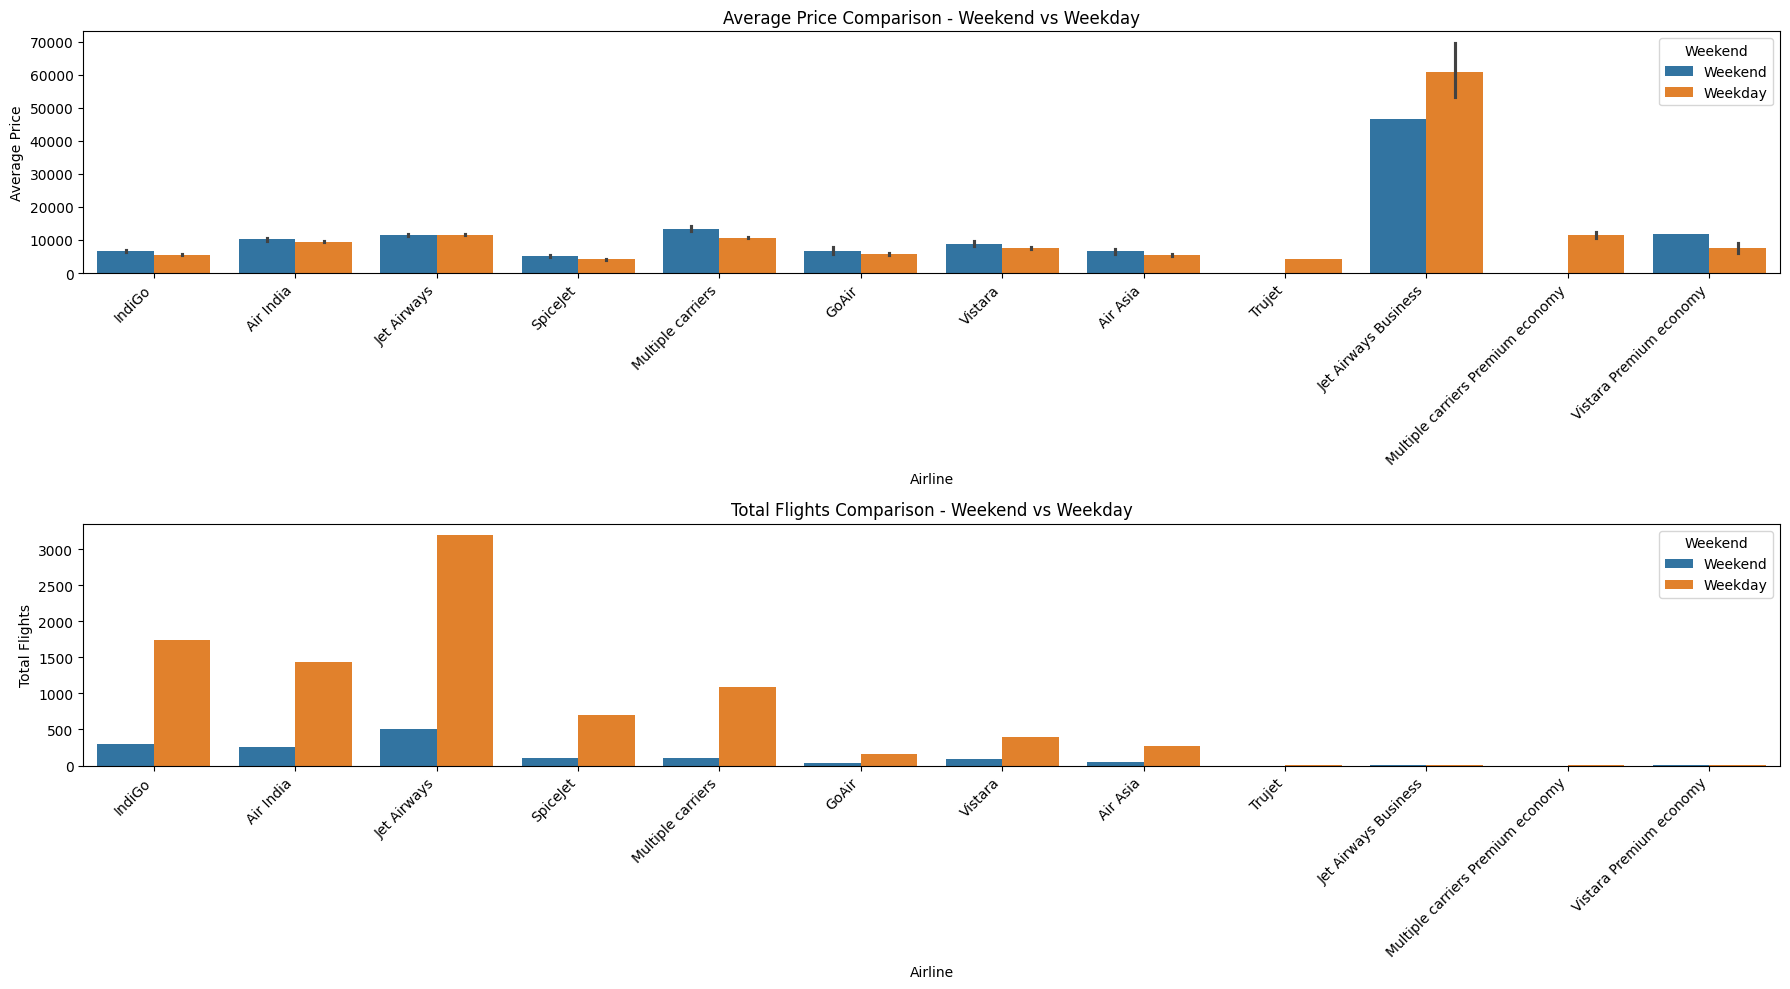

In [166]:
# Tạo biến mới "DayType" để xác định ngày thuộc weekend hay ngày thường
day_type = merged_data['Weekend'].apply(lambda x: 'Weekend' if x == 1 else 'Weekday')

# Thiết lập kích thước đồ thị
plt.figure(figsize=(18, 10))

# Vẽ biểu đồ giá trung bình theo hãng và ngày
plt.subplot(2, 1, 1)
sns.barplot(x='Airline', y='Price', hue=day_type, data=merged_data)
plt.title('Average Price Comparison - Weekend vs Weekday')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')


# Vẽ biểu đồ số chuyến bay theo hãng và ngày
plt.subplot(2, 1, 2)

sns.countplot(x='Airline', hue=day_type, data=merged_data)
plt.title('Total Flights Comparison - Weekend vs Weekday')
plt.ylabel('Total Flights')
plt.xticks(rotation=45, ha='right')

# Tăng khoảng cách giữa các đồ thị
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

### **10.2. Kết luận**

#### Biểu đồ giá vé cho thấy rằng giá vé máy bay trung bình cao hơn vào cuối tuần so với các ngày trong tuần. Sự chênh lệch giá này lớn hơn đối với các hãng hàng không giá rẻ hơn. Trong khi hãng hàng không Jet Airways Bussiness có giá mắc nhất thì trái ngược lại.

#### Biểu đồ số lượng chuyến bay cho thấy rằng số lượng chuyến bay trung bình thấp hơn vào cuối tuần so với các ngày trong tuần. Sự chênh lệch số lượng chuyến bay này cũng lớn hơn đối với các hãng hàng không giá rẻ hơn. Ví dụ, số lượng chuyến bay trung bình của Jet Airways vào các ngày trong tuần là  hơn 3.000 chuyến, trong khi số lượng chuyến bay trung bình của IndiGo vào các ngày trong tuần là hơn 1.500 chuyến.

#### Có một số lý do giải thích cho sự chênh lệch giá và số lượng chuyến bay giữa các ngày trong tuần và cuối tuần:
* Trong trường hợp này, nhu cầu đi lại trong tuần cao hơn do mọi người đi làm
hoặc đi học.
* Các hãng hàng không cũng thường tăng số lượng chuyến bay trong tuần để đáp ứng nhu cầu cao hơn.


## 11. So sánh giá, số chuyến bay giữa các tháng theo hãng

### 11.1. Visualize:
#### Lý do lựa chọn biểu đồ để visualize dữ liệu này là vì biểu đồ phù hợp để thể hiện xu hướng thay đổi của dữ liệu theo thời gian. Trong trường hợp này, dữ liệu thể hiện giá vé máy bay và số lượng chuyến bay trung bình của các hãng hàng không khác nhau giữa các tháng. Biểu đồ giúp người xem dễ dàng nhận thấy xu hướng tăng hay giảm của giá vé và số lượng chuyến bay máy bay trong các tháng. Điều này giúp người xem dễ dàng so sánh giá vé và số lượng chuyến bay của các hãng hàng không với nhau.

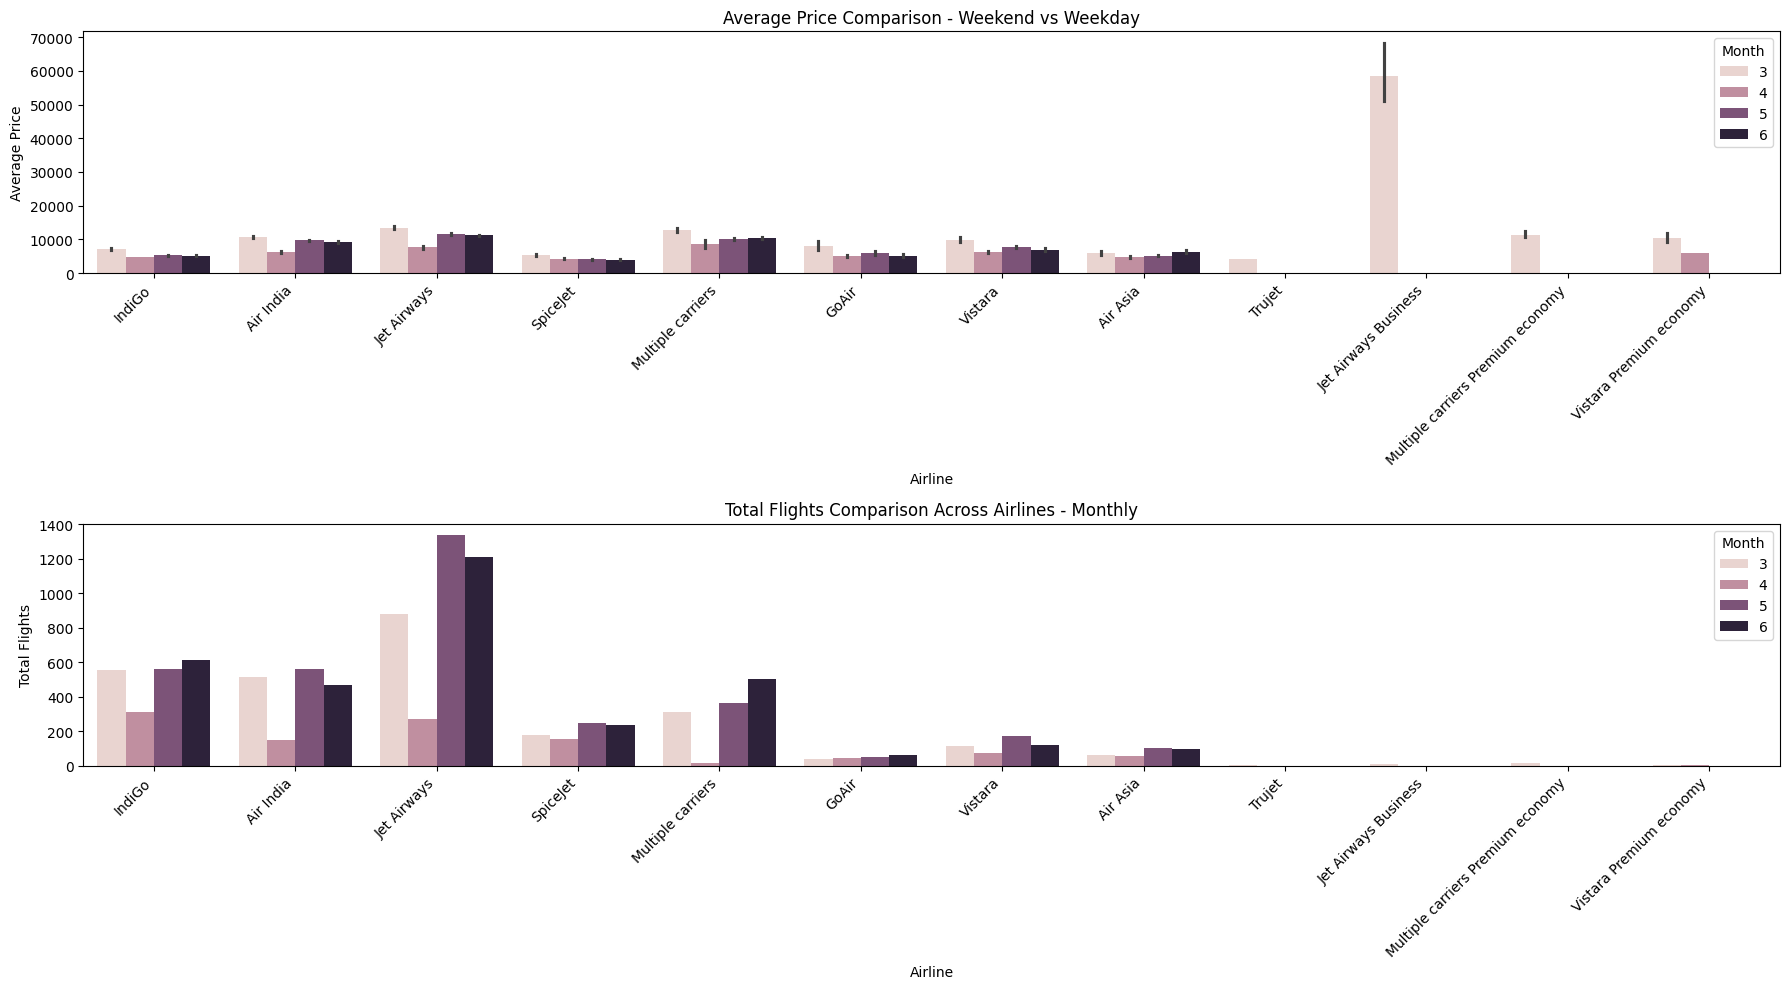

In [167]:
# Thiết lập kích thước đồ thị
plt.figure(figsize=(18, 10))

# Vẽ biểu đồ giá trung bình theo hãng và tháng

plt.subplot(2, 1, 1)
sns.barplot(x='Airline', y='Price', hue='Month', data=merged_data)
plt.title('Average Price Comparison - Weekend vs Weekday')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Vẽ biểu đồ số chuyến bay theo hãng và tháng
plt.subplot(2, 1, 2)

sns.countplot(x='Airline', hue='Month', data=merged_data)
plt.title('Total Flights Comparison Across Airlines - Monthly')
plt.ylabel('Total Flights')
plt.xticks(rotation=45, ha='right')
# Tăng khoảng cách giữa các đồ thị
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

### 11.2. Kết luận
Giá vé máy bay trung bình của các hãng hàng không trong tháng 3 có xu hướng cao nhất.
Theo biểu đồ, các hãng hàng không có số lượng chuyến bay nhiều nhất trong tháng 5 và tháng 6. Một số hãng hàng không khác có số lượng chuyến bay ít hơn đáng kể, tập trung vào tháng 3.


## 12. Giá theo info tổng quát

### 12.1. Visualize:
#### Biểu đồ cột là một lựa chọn tốt để visualize dữ liệu này vì nó cho phép người dùng so sánh trực quan các mức giá khác nhau. Biểu đồ cũng hiển thị dữ liệu theo loại chuyến bay, cho phép người dùng thấy sự khác biệt về giá vé giữa các loại chuyến bay.

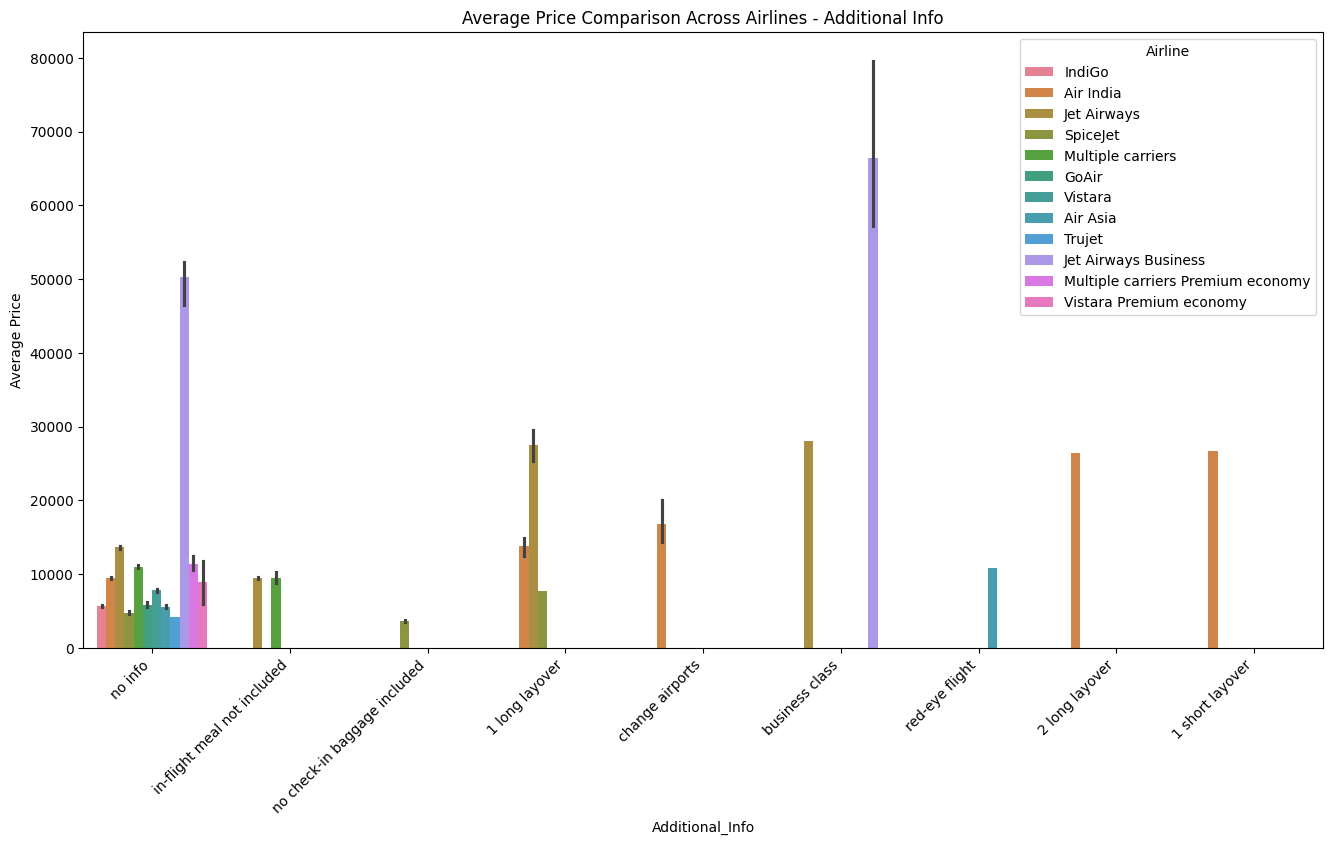

In [168]:
# Thiết lập kích thước đồ thị
plt.figure(figsize=(16, 8))

# Vẽ biểu đồ giá trung bình theo Additional_info và hãng
sns.barplot(x='Additional_Info', y='Price', hue='Airline', data=merged_data)
plt.title('Average Price Comparison Across Airlines - Additional Info')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Hiển thị đồ thị
plt.show()


### 12.2. Kết luận

#### Biểu đồ cho thấy rằng giá vé máy bay trung bình cao hơn đối với các chuyến bay có thêm thông tin. Cụ thể, giá vé máy bay trung bình cho các chuyến bay không có thông tin là 10.000 Rupee. Trong khi giá vé máy bay trung bình cho các chuyến bay có thông tin layover thường cao trên khoảng là 20.000 Rupee.

Theo ngày, điểm đi, điểm đến

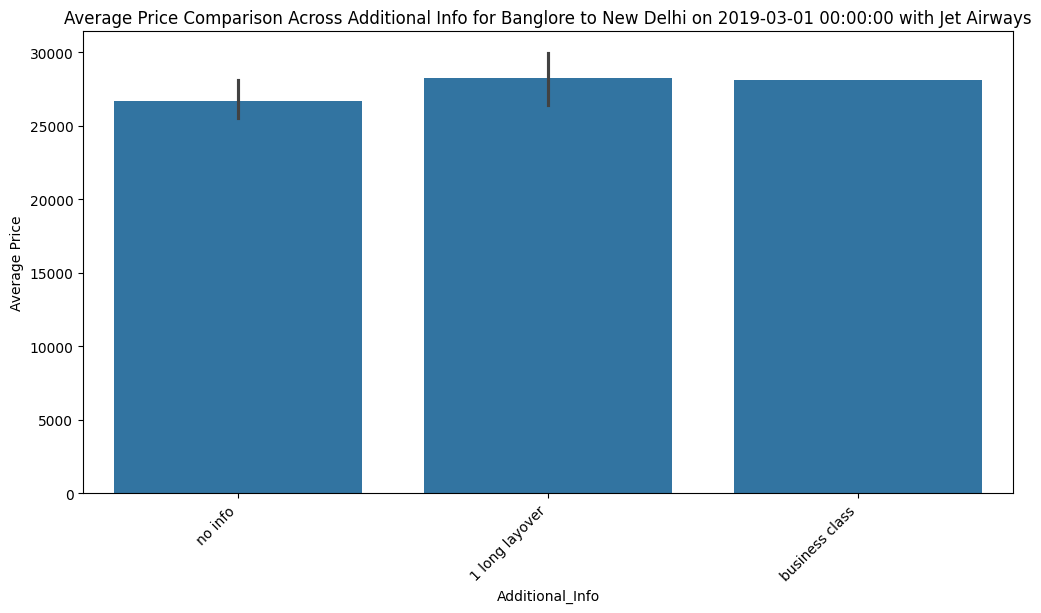

In [169]:
# Chọn một ngày, một điểm đi và một điểm đến cụ thể
selected_date = '01/03/2019'  # Đổi thành ngày mong muốn
selected_source = 'Banglore'     # Đổi thành điểm đi mong muốn
selected_destination = 'New Delhi'  # Đổi thành điểm đến mong muốn
selected_date=pd.to_datetime(selected_date, format='%d/%m/%Y')
selected_airline = 'Jet Airways'
# Lọc dữ liệu cho các điều kiện được chọn
selected_data = merged_data[(merged_data['Date_of_Journey'] == selected_date) &
                   (merged_data['Source'] == selected_source) &
                   (merged_data['Destination'] == selected_destination)&
                   (merged_data['Airline'] == selected_airline)]

# Kiểm tra xem DataFrame có trống không
if not selected_data.empty:
    # Thiết lập kích thước đồ thị
    plt.figure(figsize=(12, 6))

    # Vẽ biểu đồ giá trung bình theo Additional_Info
    sns.barplot(x='Additional_Info', y='Price', data=selected_data)
    plt.title(f'Average Price Comparison Across Additional Info for {selected_source} to {selected_destination} on {selected_date} with {selected_airline}')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45, ha='right')

    # Hiển thị đồ thị
    plt.show()
else:
    print("No data found for the selected conditions.")

## 13. Hãy cho biết số Route và số chuyến bay của mỗi hành trình (Source-Destination).
### 13.1. Visualize
Lí do chọn biểu đồ:
- Hiển Thị Sự So Sánh Rõ Ràng: Biểu đồ cột giúp hiển thị mức độ khác biệt giữa các hành trình dựa trên số lượng chuyến bay và số lượng Route một cách rõ ràng. Các cột có thể được so sánh một cách dễ dàng với nhau.
- Dễ Đọc và Hiểu: Mắt người đọc thường dễ dàng nhận biết và so sánh độ cao của các cột hơn là so sánh các giá trị trong bảng.

(Thêm câu visualize này để có thể biết được đâu là "Hành trình" mà mọi người thường đi nhất, và "Hành trình" đó có bao nhiêu route, để từ đó có thể giúp phân phối các chuyến bay cho hợp lý, ví dụ "Hành trình" nào mà mọi người thường đi thì mở thêm route/tăng số lượng chuyến bay)

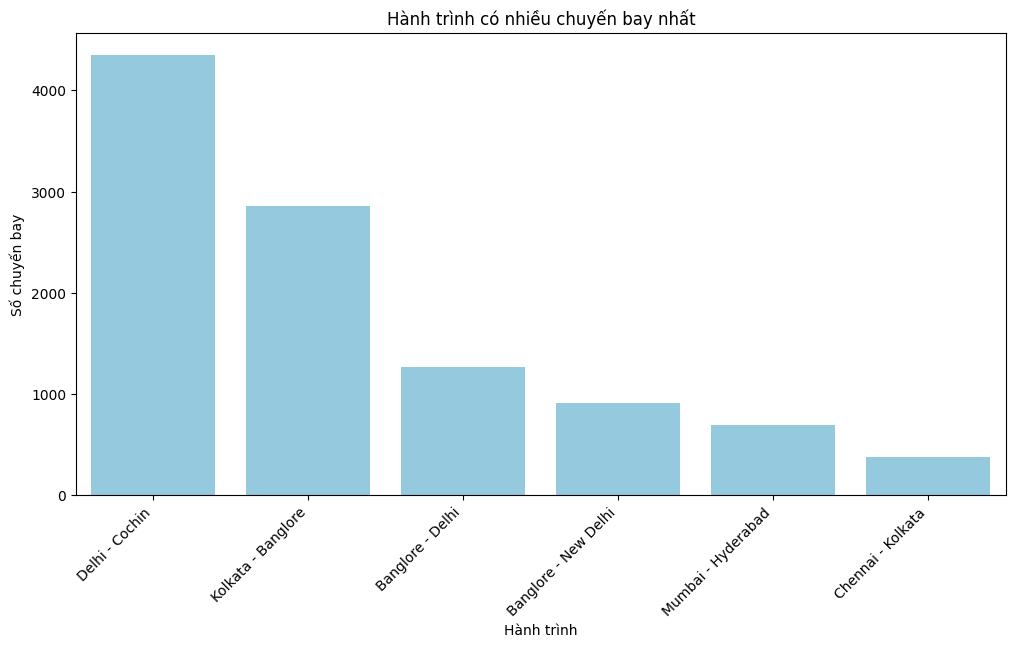

In [170]:
# Lọc và đếm số chuyến bay cho mỗi hành trình
flight_count = merged_data.groupby(['Source', 'Destination']).size().reset_index(name='Count')

# Sắp xếp theo số lượng chuyến bay giảm dần
flight_count = flight_count.sort_values(by='Count', ascending=False)

# Tạo cột mới 'Source-Destination' bằng cách kết hợp 'Source' và 'Destination'
flight_count['Source-Destination'] = flight_count['Source'] + ' - ' + flight_count['Destination']

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 6))
sns.barplot(x='Source-Destination', y='Count', data=flight_count, color='skyblue')  # Chọn màu skyblue hoặc màu bạn muốn
plt.title('Hành trình có nhiều chuyến bay nhất')
plt.xlabel('Hành trình')
plt.ylabel('Số chuyến bay')
plt.xticks(rotation=45, ha='right')
plt.show()

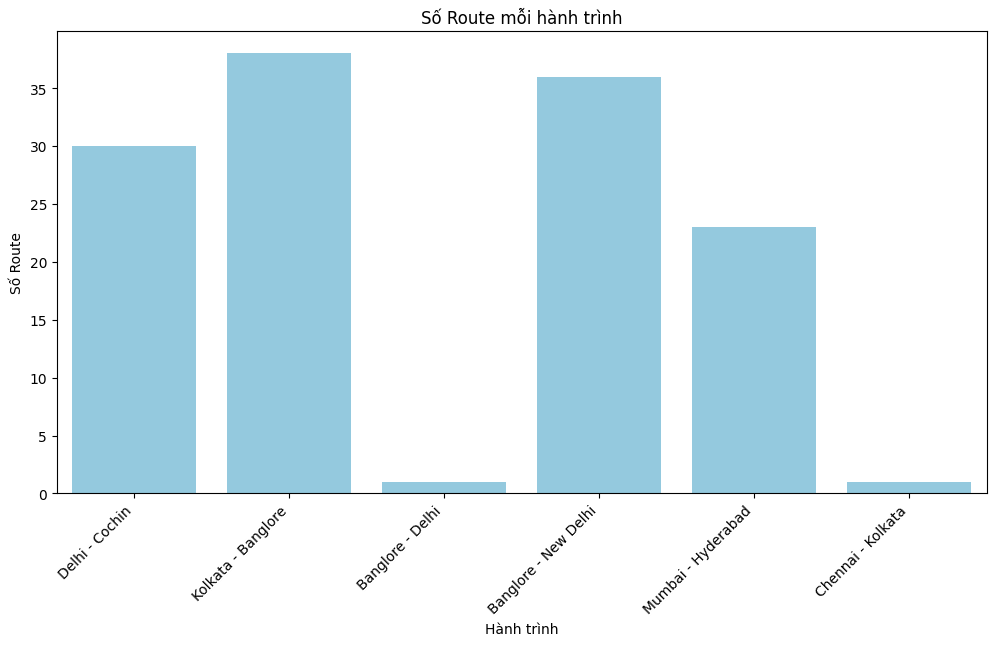

In [171]:
# Lấy số lượng Route cho mỗi cặp "Source-Destination" từ merged_data
flight_count['Num_Routes'] = flight_count.apply(lambda row: len(merged_data[(merged_data['Source'] == row['Source']) & (merged_data['Destination'] == row['Destination'])]['Route'].unique()), axis=1)

# Sắp xếp theo số lượng chuyến bay giảm dần
flight_count = flight_count.sort_values(by='Count', ascending=False)

# Vẽ biểu đồ cột cho số lượng Route
plt.figure(figsize=(12, 6))
sns.barplot(x='Source-Destination', y='Num_Routes', data=flight_count, color='skyblue')
plt.title('Số Route mỗi hành trình')
plt.xlabel('Hành trình')
plt.ylabel('Số Route')
plt.xticks(rotation=45, ha='right')
plt.show()


### 13.2. Kết luận
- Delhi-Cochin là tuyến bay (hành trình) có nhiều chuyến bay nhất, nhưng từ Kolkata-Banglore thì có nhiều Route nhất.
- Từ Chennai dến Kolkata thì có ít chuyến bay nhất và có ít route nhất (1 route)

##  **14. Với một Source và Destination thì mức giá giữa các Route thay đổi thế nào?**

### 14.1. Visualize
Dữ liệu cần thể hiện là mức giá trung bình của các Route, với một Source và Destination cố định. Mức giá trung bình của các Route là một đại lượng số, và các Route cần được so sánh với nhau. Do đó, biểu đồ thích hợp nhất để thể hiện dữ liệu này là biểu đồ biểu đồ cột.

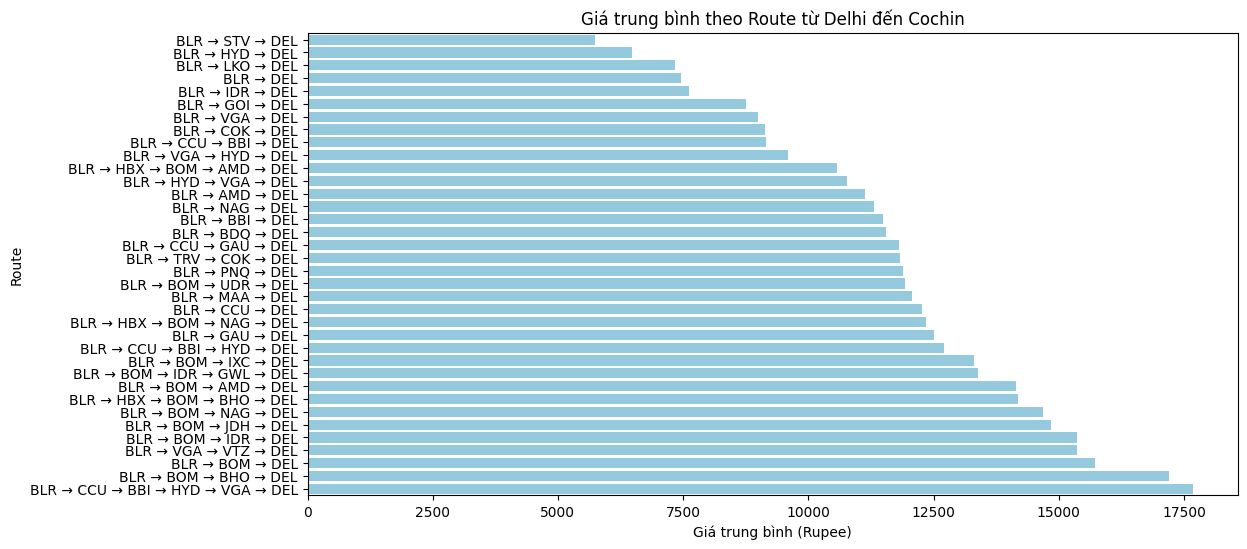

In [172]:
# Các cặp Source và Destination: Delhi-Cochin, Kolkata-Banglore,Banglore-Delhi, Banglore-New Delhi, Mumbai-Hyderabab, Chennai-Kolkata
# Xác định source và destination cố định
source = 'Banglore'
destination = 'New Delhi'

# Lọc dữ liệu cho source và destination cụ thể
filtered_data = merged_data[(merged_data['Source'] == source) & (merged_data['Destination'] == destination)]


# Tính giá trung bình cho mỗi route
average_prices = filtered_data.groupby('Route')['Price'].mean().reset_index()

# Sắp xếp theo giá trung bình tăng dần
average_prices = average_prices.sort_values(by='Price')

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=average_prices, color='skyblue')
plt.title('Giá trung bình theo Route từ Delhi đến Cochin')
plt.xlabel('Giá trung bình (Rupee)')
plt.ylabel('Route')
plt.show()

# Kết luận các điểm chính quan sát được từ dữ liệu từ các gợi ý trên


# Ngoài các đặc trưng trong tập dữ liệu, các yếu tố nào có khả năng ảnh hưởng đến giá vé chuyến bay?



Ngoài các đặc trưng đã được cung cấp, có một số yếu tố khác có thể ảnh hưởng đến giá vé máy bay:

*   **Class (hạng ghế):** Hạng ghế như Economy, Business, hoặc First Class có thể ảnh hưởng đến giá vé.
*   **Loại máy bay hoặc model:** Một số hãng hàng không sử dụng các loại máy bay khác nhau, và giá vé có thể phụ thuộc vào loại máy bay đó.
*   **Thời điểm mua vé (Advance Booking):** Giá vé có thể thay đổi tùy thuộc vào thời điểm bạn mua vé. Vé được đặt sớm có thể có giá thấp hơn so với việc mua vé gần thời điểm bay.
*   **Mùa du lịch:** Trong những mùa du lịch cao điểm, giá vé có thể tăng lên do nhu cầu cao.
*   **Ưu đãi đặc biệt và khuyến mãi:** Các chương trình khuyến mãi, mã giảm giá, hoặc ưu đãi đặc biệt từ hãng hàng không cũng có thể ảnh hưởng đến giá vé.

*   **Dịch vụ đi kèm (Additional Services):** Một số hãng hàng không có thể cung cấp dịch vụ đi kèm hoặc tiện ích khác nhau, ảnh hưởng đến giá vé.
*   **Thị trường và cạnh tranh (Market and Competition):** Sự cạnh tranh mạnh mẽ có thể dẫn đến các chiến lược giảm giá, khuyến mãi, và cải tiến dịch vụ để duy trì hoặc tăng cường thị phần.
*   **Dịch bệnh (Health Concerns):** Vấn đề liên quan đến dịch bệnh có thể ảnh hưởng đến giá vé máy bay. Trong thời kỳ dịch (VD: Covid 19), nhu cầu và giá vé có thể biến động do các biện pháp an toàn, quy định về hạn chế du lịch, và sự lo ngại của hành khách.
*   **Vấn đề kinh tế chính trị:**  Tình hình kinh tế và chính trị của quốc gia đó, hoặc cả thế giới có thể ảnh hưởng đến giá vé máy bay. Sự ổn định kinh tế và chính trị thường giữ cho giá vé ổn định, trong khi các biến động và không chắc chắn có thể dẫn đến thay đổi giá vé. Ví dụ xung đột giữa Nga và Ukraine, Israel với Palestine khiến nhiều người muốn di dân, và kinh tế bị ảnh hưởng làm giá vé máy bay tăng cao.
*   **Vấn đề về nhiên liệu:** Giá nhiên liệu là một yếu tố quan trọng trong chi phí hoạt động của hãng hàng không. Sự biến động của giá nhiên liệu có thể ảnh hưởng đến chi phí vận hành và do đó có thể gây biến động giá vé.


Để hiểu rõ hơn về tác động của các yếu tố này, chúng ta cần có thêm data để thêm vào và phân tích.






# Dự đoán giá vé

In [173]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Build the Regression / Regressor models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import statsmodels.api as sm

In [174]:
# Tạo DataFrame
df = pd.DataFrame(merged_data)

In [175]:
def drop_useless_col(df, cols):
    df.drop(columns=cols, axis=1, inplace=True)
    return df
#Bỏ Duration vì đã có arrival_time
#Bỏ date_of journey vì đã có day, month, year là 2019 nên không tính
#
df = drop_useless_col(df, [ 'Route', 'Duration', 'Date_of_Journey', 'Arrival_Date', 'Departure_Hour','Arrival_Hour'])
df_bk=df.copy()
df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend
0,IndiGo,Banglore,New Delhi,22:20,01:10,0.0,no info,3897,24,3,22,3,Sunday,1
1,Air India,Kolkata,Banglore,05:50,13:15,2.0,no info,7662,1,7,5,5,Wednesday,0
2,Jet Airways,Delhi,Cochin,09:25,04:25,2.0,no info,13882,9,19,9,6,Sunday,1
3,IndiGo,Kolkata,Banglore,18:05,23:30,1.0,no info,6218,12,5,18,5,Sunday,1
4,IndiGo,Banglore,New Delhi,16:50,21:35,1.0,no info,13302,1,5,16,3,Friday,0


In [176]:
# Coverting the labels into a numeric form using Label Encoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend
0,3,0,5,211,12,0,7,3897,24,3,22,3,3,1
1,1,3,0,31,104,2,7,7662,1,7,5,5,6,0
2,4,2,1,70,30,2,7,13882,9,19,9,6,3,1
3,3,3,0,164,217,1,7,6218,12,5,18,5,3,1
4,3,0,5,149,194,1,7,13302,1,5,16,3,0,0


In [177]:
# storing the Dependent Variables in X and Independent Variable in Y
x = df.drop(axis=1, columns=['Price'])
y = df['Price']

In [178]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8368, 13), (2093, 13), (8368,), (2093,))

- Sử dụng OLS Linear Regression được học ở lý thuyết để dự đoán.
- Sau khi thử thêm bớt các biến độc lập thì nhận thấy chỉ khi bỏ giá trị constant mới thay đổi từ 43% lên 87%.

In [179]:

#X = sm.add_constant(x_train)  # Thêm hạng mục hằng số (intercept)
result_model = sm.OLS(y_train, x_train).fit()
print(result_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              4691.
Date:                Fri, 05 Jan 2024   Prob (F-statistic):                        0.00
Time:                        15:33:43   Log-Likelihood:                         -80192.
No. Observations:                8368   AIC:                                  1.604e+05
Df Residuals:                    8355   BIC:                                  1.605e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

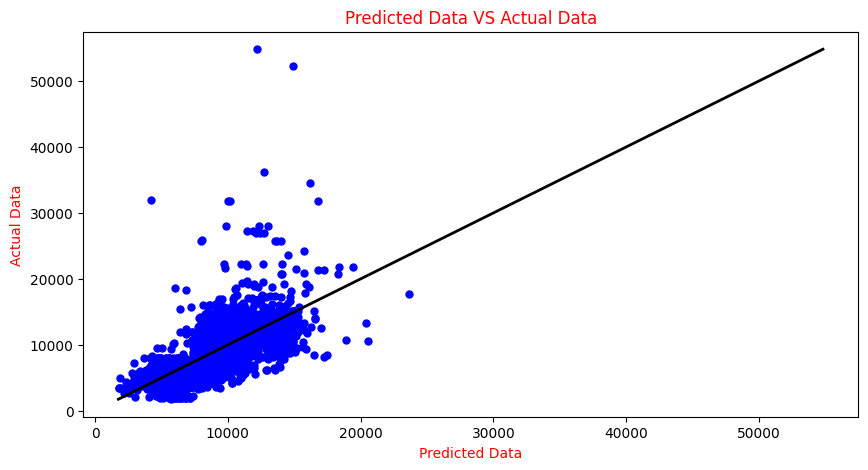

In [180]:
#Plotting the results
plt.figure(figsize=(10,5))
y_pred_ln=result_model.predict(x_test)
plt.scatter(y_pred_ln,y_test,c='blue',marker='o',s=25)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],c='black',lw=2)
plt.xlabel('Predicted Data',c='red')
plt.ylabel('Actual Data',c='red')
plt.title('Predicted Data VS Actual Data',c='red')
plt.show()

- R2 Score: 0.875 gần 1 cho thấy mô hình có độ chính xác cao.

- Thử áp dụng 10 model phổ biến:

In [181]:
# Create objects of Regression / Regressor models with default hyper-parameters

modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelbag = BaggingRegressor()
modelrfr = RandomForestRegressor()
modelSVR = SVR()
modelXGR = xgb.XGBRegressor()
modelKNN = KNeighborsRegressor(n_neighbors=5)
modelETR = ExtraTreesRegressor()
modelRE=Ridge()
modelLO=linear_model.Lasso(alpha=0.1)

modelGBR = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                     init=None, random_state=None, max_features=None,
                                     alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

# Evalution matrix for all the algorithms

MM = [modelmlg, modeldcr, modelrfr, modelKNN, modelETR, modelGBR, modelXGR, modelbag,modelRE,modelLO]

# Initialize an empty DataFrame
a = {'Model Name': [], 'Mean_Absolute_Error_MAE': [], 'Adj_R_Square': [],
     'Root_Mean_Squared_Error_RMSE': [], 'Mean_Absolute_Percentage_Error_MAPE': [],
     'Mean_Squared_Error_MSE': [], 'Root_Mean_Squared_Log_Error_RMSLE': [], 'R2_score': []}
Results = pd.DataFrame(a)
results_list = []
for model in MM:
    # Fit the model with train data
    model.fit(x_train, y_train)

    # Predict the model with test data
    y_pred = model.predict(x_test)
    # Print the model name
    print('Model Name:', type(model).__name__)

    # Evaluation metrics for Regression analysis
    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred), 3))
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred), 3))
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred), 6))

    # Calculate Adjusted R squared values
    r_squared = round(metrics.r2_score(y_test, y_pred), 6)
    adjusted_r_squared = round(1 - (1 - r_squared) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1), 6)
    print('Adj R Square:', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')

    # Append results to the Results DataFrame
    new_row = {'Model Name': type(model).__name__,
               'Mean_Absolute_Error_MAE': round(metrics.mean_absolute_error(y_test, y_pred), 3),
               'Adj_R_Square': adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3),
               'Mean_Squared_Error_MSE': round(metrics.mean_squared_error(y_test, y_pred), 3),
               'R2_score': round(metrics.r2_score(y_test, y_pred), 6)}

    results_list.append(new_row)

# Create a DataFrame from the results_list
Results = pd.DataFrame(results_list)


Model Name: LinearRegression
Mean Absolute Error (MAE): 2500.638
Mean Squared Error (MSE): 12548837.09
Root Mean Squared Error (RMSE): 3542.434
R2_score: 0.433386
Adj R Square: 0.429843
------------------------------------------------------------------------------------------------------------
Model Name: DecisionTreeRegressor
Mean Absolute Error (MAE): 798.059
Mean Squared Error (MSE): 4222737.056
Root Mean Squared Error (RMSE): 2054.93
R2_score: 0.809332
Adj R Square: 0.80814
------------------------------------------------------------------------------------------------------------


Model Name: RandomForestRegressor
Mean Absolute Error (MAE): 698.75
Mean Squared Error (MSE): 2879669.738
Root Mean Squared Error (RMSE): 1696.959
R2_score: 0.869975
Adj R Square: 0.869162
------------------------------------------------------------------------------------------------------------
Model Name: KNeighborsRegressor
Mean Absolute Error (MAE): 1925.644
Mean Squared Error (MSE): 10025743.41
Root Mean Squared Error (RMSE): 3166.345
R2_score: 0.547311
Adj R Square: 0.54448
------------------------------------------------------------------------------------------------------------
Model Name: ExtraTreesRegressor
Mean Absolute Error (MAE): 731.413
Mean Squared Error (MSE): 3111280.934
Root Mean Squared Error (RMSE): 1763.882
R2_score: 0.859517
Adj R Square: 0.858639
------------------------------------------------------------------------------------------------------------
Model Name: GradientBoostingRegressor
Mean Absolute Error (MAE): 1292.704
Mean Squared Error (MSE): 4375520.

c:\Users\Vanniee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.590e+10, tolerance: 1.773e+07
  model = cd_fast.enet_coordinate_descent(


In [182]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','ExtraTreesRegressor','GradientBoostingRegressor','XGBRegressor','BaggingRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
#sai số tuyệt đối trung bình giữa giá trị dự đoán và giá trị thực tế.
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
#căn bậc hai của mức trung bình của chênh lệch bình phương giữa giá trị dự đoán và giá trị thực tế.
#RMSE thấp hơn cho thấy độ chính xác tốt hơn.
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
#trung bình của chênh lệch bình phương giữa giá trị dự đoán và giá trị thực tế.
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result

,Model_Name,Adj_R_Square,Mean_Absolute_Error_MAE,Root_Mean_Squared_Error_RMSE,Mean_Squared_Error_MSE,R2_score
0,XGBRegressor,0.880717,777.633,1620.297,2.625361e+06,0.881458
1,RandomForestRegressor,0.869162,698.750,1696.959,2.879670e+06,0.869975
2,ExtraTreesRegressor,0.858639,731.413,1763.882,3.111281e+06,0.859517
3,BaggingRegressor,0.857288,746.372,1772.286,3.140998e+06,0.858175
4,DecisionTreeRegressor,0.808140,798.059,2054.930,4.222737e+06,0.809332
5,GradientBoostingRegressor,0.801198,1292.704,2091.775,4.375521e+06,0.802433
6,KNeighborsRegressor,0.544480,1925.644,3166.345,1.002574e+07,0.547311
7,LinearRegression,0.429843,2500.638,3542.434,1.254884e+07,0.433386
8,Lasso Regression,0.429837,2500.655,3542.452,1.254897e+07,0.433380
9,Ridge Regression,0.429828,2500.667,3542.483,1.254918e+07,0.433371


- Nhận thấy top3 model là RandomForestRegressor, BaggingRegressor, XGBRegressor.
- Dự đoán thử giá trị price ở tập test với model RandomForestRegressor.

- Model RandomForestRegressor

In [183]:
#Trainig the model with
model_rfr = modelrfr.fit(x_train, y_train)
# Predict the model with test data
y_pred = model_rfr.predict(x_test)
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
#Thêm giá dự đoán vào df
result=df_bk.merge(out,left_index=True,right_index=True)
#Thêm giá trị chênh lệch tuyệt đối giữa giá vé thực tế và dự đoán 
result['|actual-pred|'] = abs(result['Price_actual'] - result['Price_pred'])
result_sorted = result.sort_values(by='|actual-pred|', ascending=False)
print("Giá trị chênh lệch tuyệt đối lớn nhất là: ",result_sorted['|actual-pred|'].iloc[0])
result.sample(10)

Giá trị chênh lệch tuyệt đối lớn nhất là:  32121.42


,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Day,Duration_Hour,Dep_hour,Month,WeekDay,Weekend,Price_actual,Price_pred,|actual-pred|
3708,Jet Airways,Delhi,Cochin,11:00,14:15,0.0,in-flight meal not included,7202,3,3,11,6,Monday,0,7202,5187.060,2014.940
5471,Air India,Mumbai,Hyderabad,19:30,20:45,0.0,no info,15385,1,1,19,3,Friday,0,15385,10579.210,4805.790
6808,Air India,Kolkata,Banglore,12:00,18:30,2.0,no info,9626,6,30,12,6,Thursday,0,9626,10263.420,637.420
10053,Air India,Delhi,Cochin,12:00,07:40,2.0,no info,14746,6,20,12,3,Wednesday,0,14746,14795.505,49.505
6061,Multiple carriers,Delhi,Cochin,10:35,19:00,1.0,no info,9103,9,8,10,5,Thursday,0,9103,9406.010,303.010
8990,IndiGo,Delhi,Cochin,04:45,11:30,1.0,no info,14871,3,7,4,3,Sunday,1,14871,11451.510,3419.490
4315,SpiceJet,Kolkata,Banglore,09:00,11:25,0.0,no check-in baggage included,3841,21,2,9,6,Friday,0,3841,3973.520,132.520
9308,IndiGo,Kolkata,Banglore,09:35,12:20,0.0,no info,6565,1,3,9,3,Friday,0,6565,6339.450,225.550
789,Jet Airways,Banglore,Delhi,06:00,08:45,0.0,no info,7229,6,3,6,4,Saturday,0,7229,7229.000,0.000
2189,IndiGo,Kolkata,Banglore,09:20,14:15,1.0,no info,9376,24,5,9,5,Friday,0,9376,11433.660,2057.660


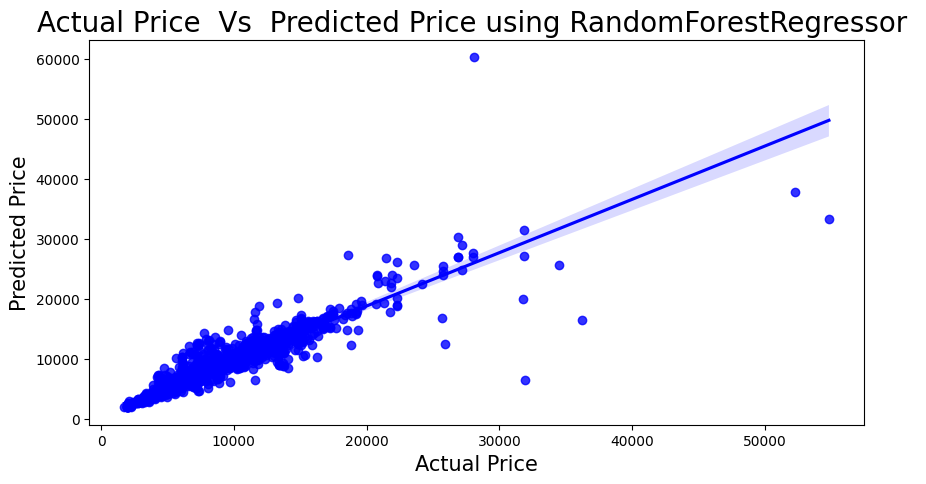

In [184]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='blue')
plt.title('Actual Price  Vs  Predicted Price using RandomForestRegressor ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

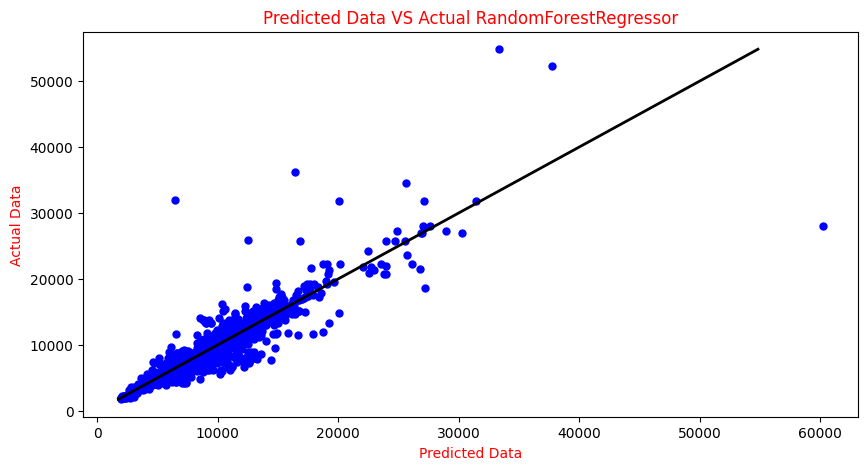

In [185]:
#Plotting the results
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_test,c='blue',marker='o',s=25)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],c='black',lw=2)
plt.xlabel('Predicted Data',c='red')
plt.ylabel('Actual Data',c='red')
plt.title('Predicted Data VS Actual RandomForestRegressor',c='red')
plt.show()

In [186]:
print("R2 của RandomForestRegressor:", model_rfr.score(x_test, y_test))

R2 của RandomForestRegressor: 0.8701530797540176


- Mô hình cho độ chính xác cao.